In [1]:
START_NUM=0;
END_NUM=150;

### Goal: Feature Importance.

The idea is to use the permutation importance to the neural network.
1. Fit the model with all the features of interest.
2. For each column:
  - Randomly permute the values in the column
  - Compute the drop in training RMSE
  - The more important the feature is, theoretically the more is the performance drop.

In [2]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.preprocessing import StandardScaler;
from sklearn.preprocessing import MinMaxScaler;
from sklearn.metrics import mean_squared_error;

2.6.0


In [3]:
pd.set_option('display.max_columns', 300);
pd.set_option('display.max_rows', 300);
tf.keras.backend.set_floatx('float64');

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [5]:
MONTHS = 60;
SPLIT = 48; # 2015-2018: training, 2019: testing.
# BATCH_SIZE = 19; # used in NN_v1
BATCH_SIZE = 24;
WINDOW_SIZE = 1;

TEST_LENGTH = MONTHS - SPLIT;

### Data preparation

In [6]:
multi_data = pd.read_csv('../data/full_dataset_unscaled.csv', index_col = 0);
zip_ids = multi_data.index.unique();

multi_data.drop(["City", "State", "Metro", "CountyName", "year", "month", "datetime"],\
                 axis = 1, inplace = True);

multi_data.head()

zri  percent_white  percent_black  percent_asian  percent_hispanic  \
zip                                                                          
1013  946.0       0.714892       0.023829       0.013748          0.230129   
1013  950.0       0.715367       0.024195       0.014023          0.229024   
1013  958.0       0.715842       0.024561       0.014299          0.227919   
1013  958.0       0.716318       0.024927       0.014574          0.226813   
1013  955.0       0.716793       0.025294       0.014850          0.225708   

      percent_native_am  percent_other_race  percent_0_17  percent_18_39  \
zip                                                                        
1013           0.000113            0.004539      0.224062       0.314378   
1013           0.000226            0.004587      0.223443       0.316319   
1013           0.000339            0.004634      0.222823       0.318260   
1013           0.000452            0.004682      0.222204       0.320201   
1013           0.000565            0.004730      0.221584       0.322142   

      percent_40_64  percent_65+  percent_rental_units_vacant  \
zip                                                             
1013       0.316595     0.144965                     0.057735   
1013       0.315346     0.144892                     0.057503   
1013       0.314097     0.144820                     0.057270   
1013       0.312847     0.144748                     0.057038   
1013       0.311598     0.144675                     0.056805   

      percent_rental_units_occupied  percent_graduate_deg  percent_bachelors  \
zip                                                                            
1013                       0.942265              0.029555           0.062456   
1013                       0.942497              0.029598           0.062682   
1013                       0.942730              0.029641           0.062908   
1013                       0.942962              0.029684           0.063134   
1013                       0.943195              0.029727           0.063359   

      percent_associates  percent_highschool  percent_less_highschool  \
zip                                                                     
1013            0.257328            0.383459                 0.218492   
1013            0.255708            0.385186                 0.217890   
1013            0.254088            0.386912                 0.217289   
1013            0.252468            0.388639                 0.216687   
1013            0.250848            0.390365                 0.216086   

      percent_commute_public_transport  percent_commute_less_30  \
zip                                                               
1013                          0.022609                 0.731245   
1013                          0.023198                 0.733361   
1013                          0.023787                 0.735477   
1013                          0.024375                 0.737593   
1013                          0.024964                 0.739709   

      percent_buildings_less_10_units  percent_buildings_10_19_units  \
zip                                                                    
1013                         0.883422                       0.030202   
1013                         0.883598                       0.030477   
1013                         0.883775                       0.030752   
1013                         0.883952                       0.031027   
1013                         0.884128                       0.031302   

      percent_buildings_20_49_units  percent_buildings_50+_units  \
zip                                                                
1013                       0.036863                     0.049514   
1013                       0.036368                     0.049557   
1013                       0.035873                     0.049601   
1013                       0.035378                     0.049644   
1013            

In [7]:
FEATURES = multi_data.shape[1] - 1;

feature_name = list(multi_data.columns);

### Utility functions

In [8]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series); #(43,)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True);
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)); #(13,43)
    dataset = dataset.shuffle(shuffle_buffer)\
                     .map(lambda window: (window[:-1, 1:], window[-1][0]));
    dataset = dataset.batch(batch_size).prefetch(1);
    return dataset;

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Frame")
    plt.ylabel("ZRI")
    plt.grid(True)

### Neural network center

In [10]:
def NN_model(dataset, termination=0, test = None):
    tf.keras.backend.clear_session();
    # dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

    class myCallbacks(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            mse = logs.get("mse");
            if(mse < termination):
                print("\nGot an mse at {:.4f} in epoch {} and stopped training\n".format(mse, epoch));
                self.model.stop_training = True;
            
    callback = myCallbacks();
    
    model = tf.keras.models.Sequential([
#         tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                           input_shape=[None]),
#       tf.keras.layers.Conv1D(filters=32, kernel_size=3,
#                           strides=1, padding="causal",
#                           activation="relu",
#                           input_shape=[None, WINDOW_SIZE, FEATURES+1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, input_shape = [None, WINDOW_SIZE, FEATURES])),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        # tf.keras.layers.SimpleRNN(8, return_sequences=True),
        #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
        tf.keras.layers.Dense(8, activation="relu"),
    #   tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1)
        # tf.keras.layers.Lambda(lambda x: x * 2.0)
    ]);
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer="adam",
                  metrics=["mae", "mse"])

    model.build((None,WINDOW_SIZE,FEATURES))
    # model.summary()

    if not test: history = model.fit(dataset, epochs=500, callbacks = [callback], verbose = 0);
    else: history = model.fit(dataset, epochs=500, validation_data=test,\
                              callbacks=[callback], verbose = 0);
    return model;

In [11]:
def NN_forecast(model, series_transformed):
    forecast = []
    results = []
    for time in range(MONTHS - WINDOW_SIZE):
        forecast.append(model.predict(series_transformed[np.newaxis, time:time + WINDOW_SIZE, 1:]))

    results = [float(x[-1][0]) for x in forecast];
    actual = list(series_transformed[WINDOW_SIZE:, 0]);
    
    return results, actual;

In [12]:
@tf.autograph.experimental.do_not_convert
def NN_test(ZONE, termination=0, plot=False):
    '''
    Input: ZONE
    Output: the RMSE of a NN model on the predicted train, partially predicted test, and complete predicted test.
    '''
    # Collection of data
    series_frame = multi_data[multi_data.index == ZONE];
    # series_frame.sort_values("datetime", ascending = True, inplace = True);
    
    # Standardization
    scaler = MinMaxScaler();
    series_transformed = scaler.fit_transform(series_frame);
    
    # Train test split
    series_train = series_transformed[:SPLIT];
    series_test = series_transformed[SPLIT-WINDOW_SIZE:];
    
    # Window the training set to make input of the NN
    dataset_train = windowed_dataset(series_train, WINDOW_SIZE, BATCH_SIZE, 60);
    # dataset_test = windowed_dataset(series_test, WINDOW_SIZE, BATCH_SIZE, 60);
    
#     for x, y in dataset_train:
#         print(np.array(x).shape, np.array(y).shape);
    
    model = NN_model(dataset_train, termination);
    
    time_train = list(range(SPLIT));
    time_test = list(range(SPLIT, MONTHS));
    
    # Forecasting
    results, actual = NN_forecast(model, series_transformed);
    
    # Compute MSE
    MSE_train = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5 * scaler.data_range_[0];
    MSE_test = mean_squared_error(actual[-TEST_LENGTH:], results[-TEST_LENGTH:])**0.5 * scaler.data_range_[0];
    
    if plot: # If the plot option is selected, plot the graph.
        time_actual = range(WINDOW_SIZE, MONTHS);
        plt.figure(figsize=(10, 6))
        plot_series(time_actual, np.array(actual)*scaler.data_range_[0]+scaler.data_min_[0]);
        plot_series(time_actual, np.array(results)*scaler.data_range_[0]+scaler.data_min_[0]);
        plt.show();

    return MSE_train, MSE_test, model, scaler, series_transformed;

### The script


Got an mse at 0.0025 in epoch 69 and stopped training



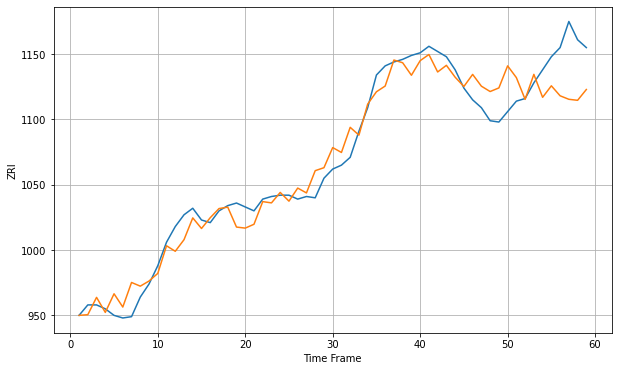

Wall time: 6.9 s
1013 11.311172388830794 31.36794233973295


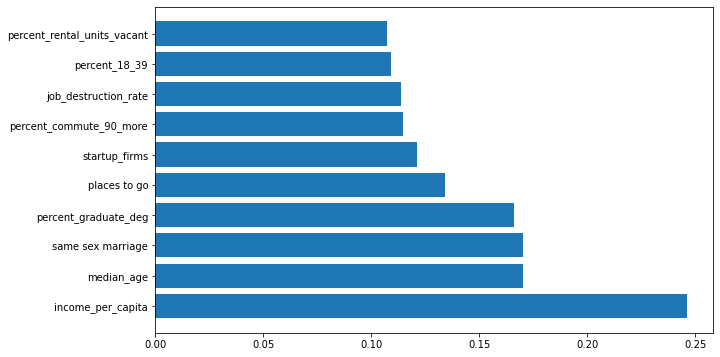


Got an mse at 0.0025 in epoch 32 and stopped training



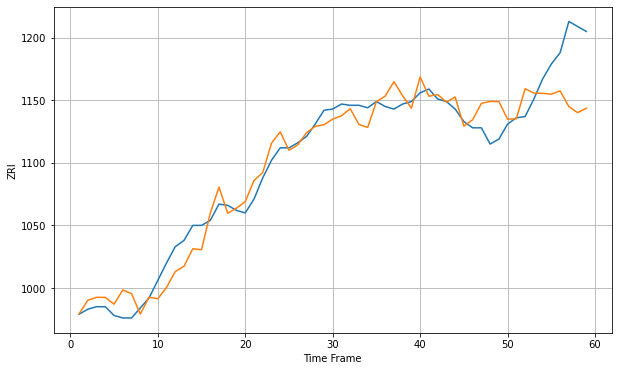

Wall time: 6.43 s
1020 11.646319390452808 38.04553596368953


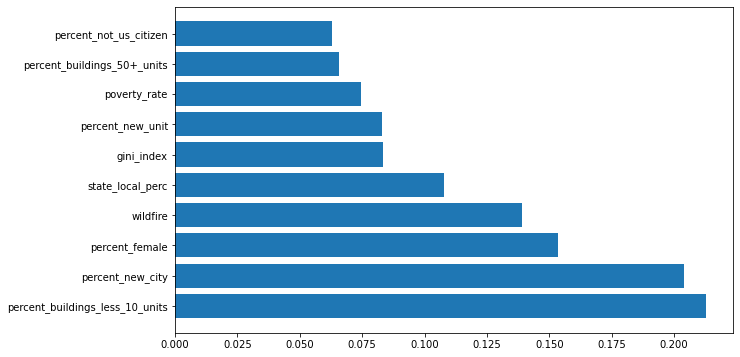


Got an mse at 0.0024 in epoch 56 and stopped training



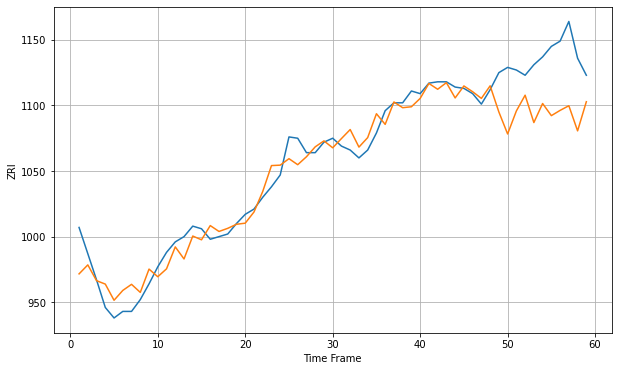

Wall time: 9.46 s
1040 10.977748141835557 41.895809921767025


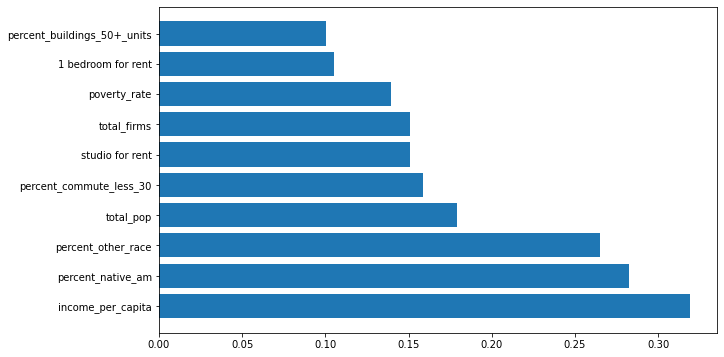


Got an mse at 0.0025 in epoch 159 and stopped training



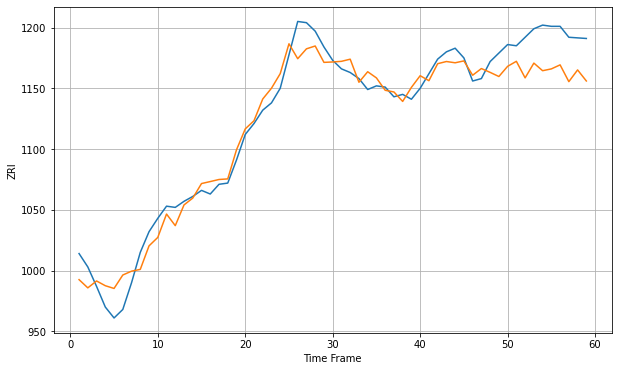

Wall time: 12.6 s
1085 12.111139860429885 28.49873459934006


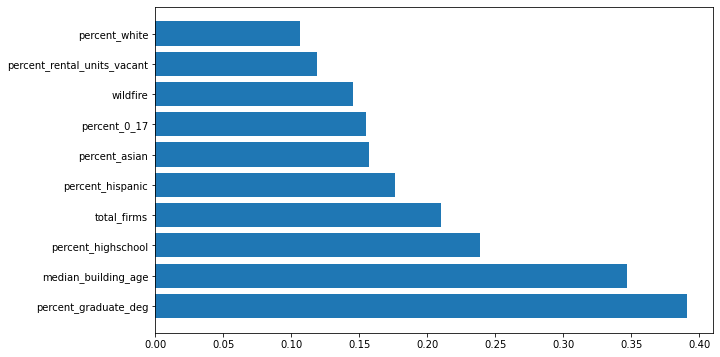


Got an mse at 0.0025 in epoch 57 and stopped training



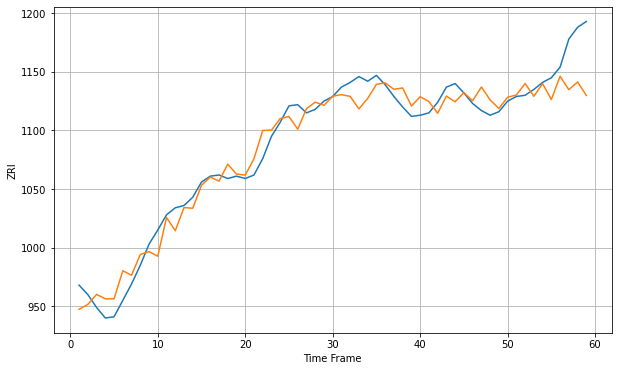

Wall time: 9.77 s
1104 12.420969224510356 27.01412712364815


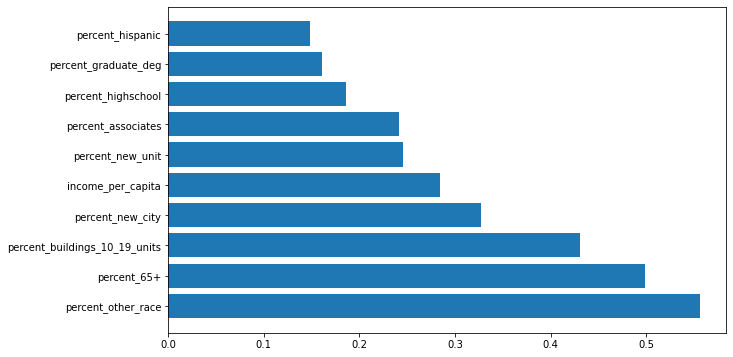


Got an mse at 0.0025 in epoch 118 and stopped training



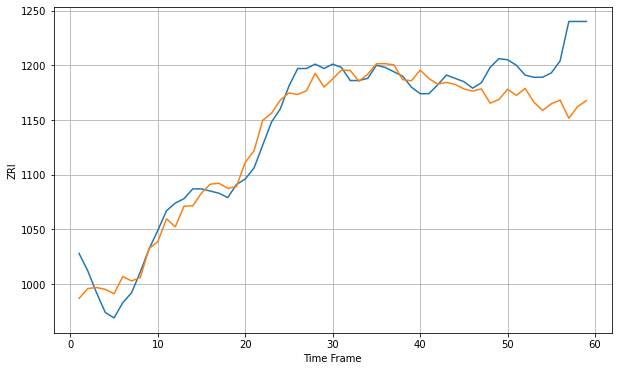

Wall time: 11.5 s
1108 13.404679081892986 47.193321575773915


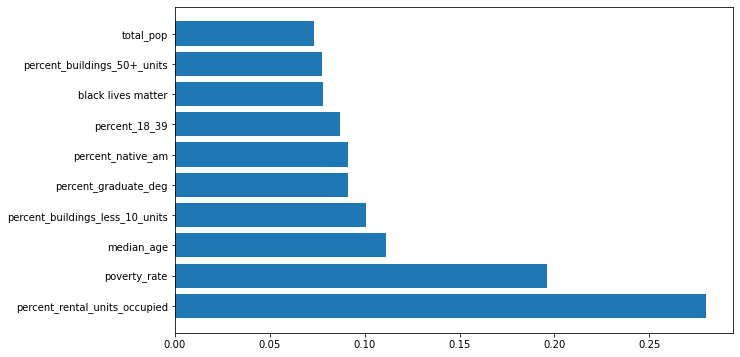


Got an mse at 0.0025 in epoch 117 and stopped training



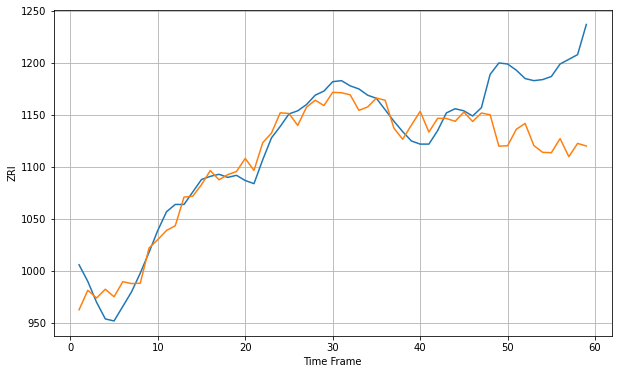

Wall time: 10.8 s
1109 14.07096496688699 75.33599410926787


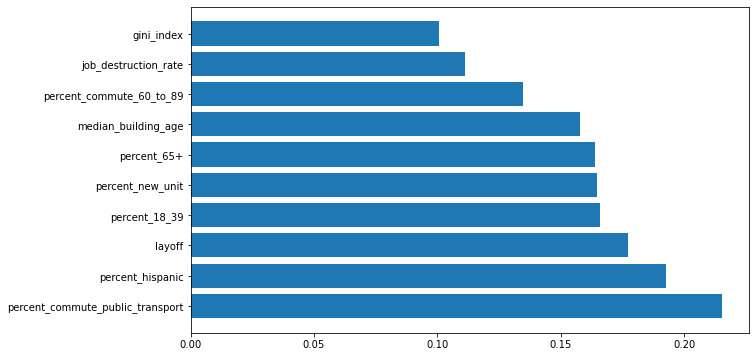


Got an mse at 0.0025 in epoch 77 and stopped training



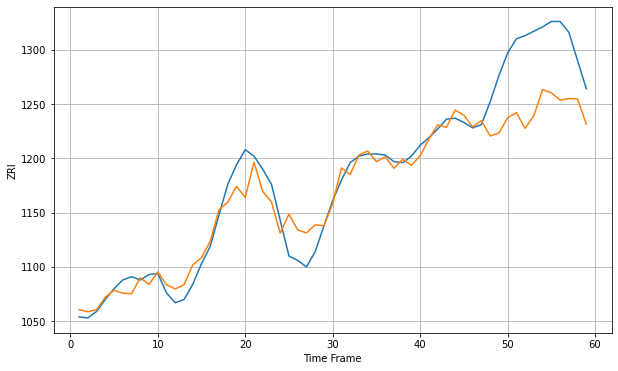

Wall time: 10.3 s
1420 14.141099263548595 60.69199000812816


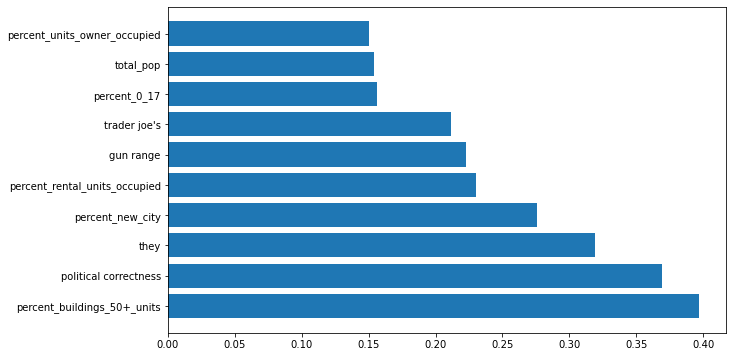


Got an mse at 0.0024 in epoch 86 and stopped training



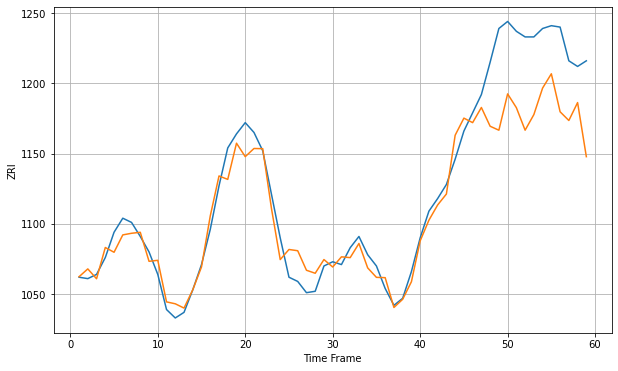

Wall time: 10.5 s
1440 10.17951369334038 53.30806378691353


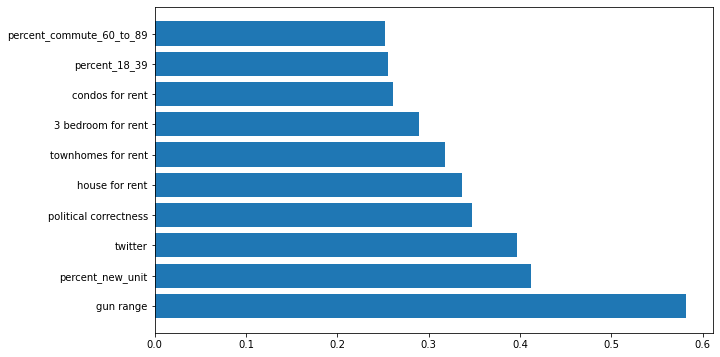


Got an mse at 0.0024 in epoch 88 and stopped training



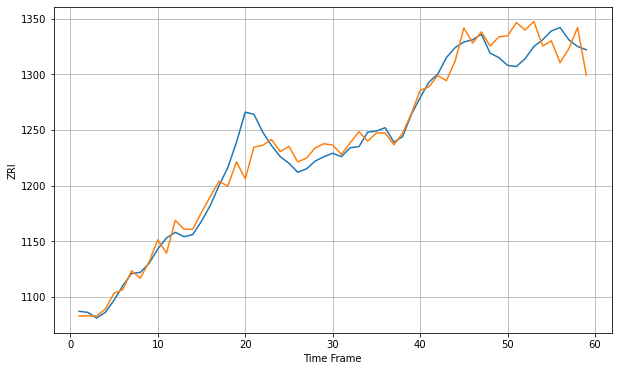

Wall time: 11 s
1453 12.873599457498157 22.009413458000687


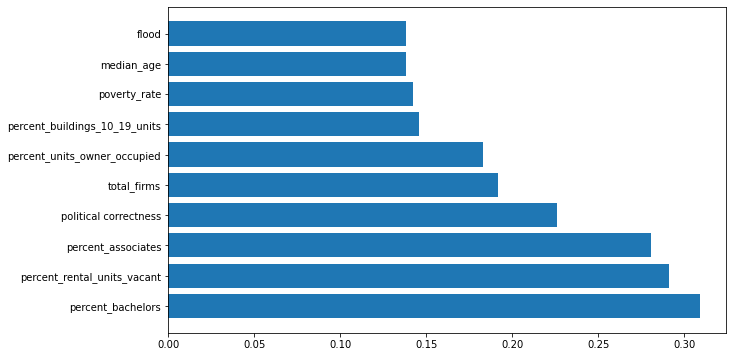


Got an mse at 0.0025 in epoch 51 and stopped training



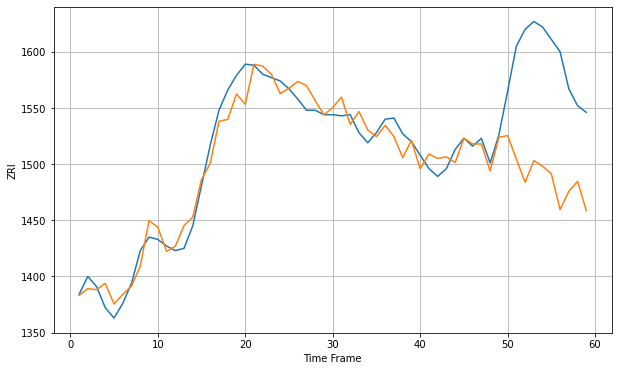

Wall time: 9.55 s
1545 13.010681087481155 98.13102778064028


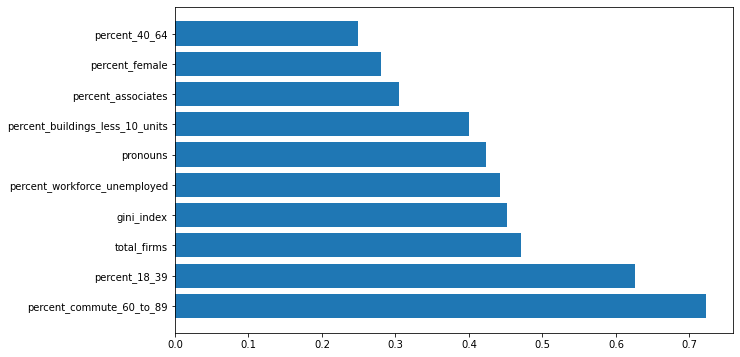


Got an mse at 0.0025 in epoch 65 and stopped training



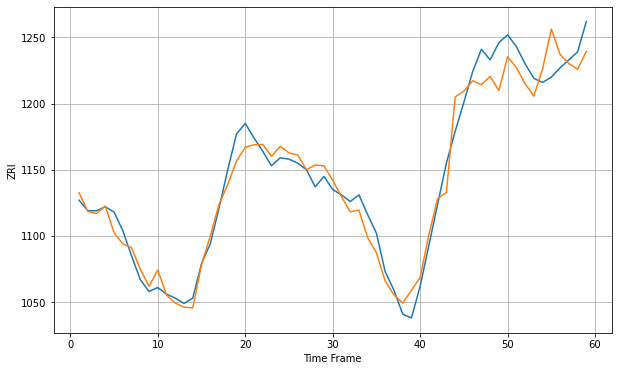

Wall time: 9.32 s
1550 11.005298325342718 19.61373202135846


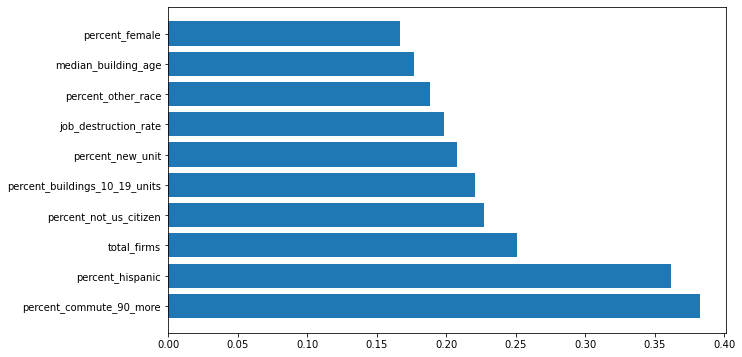


Got an mse at 0.0025 in epoch 92 and stopped training



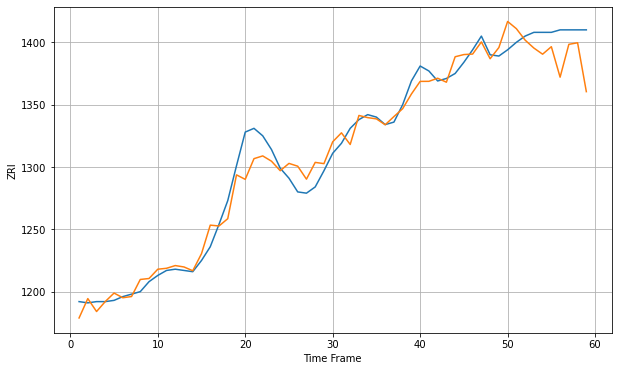

Wall time: 10.3 s
1602 10.808095157062148 21.295294853098593


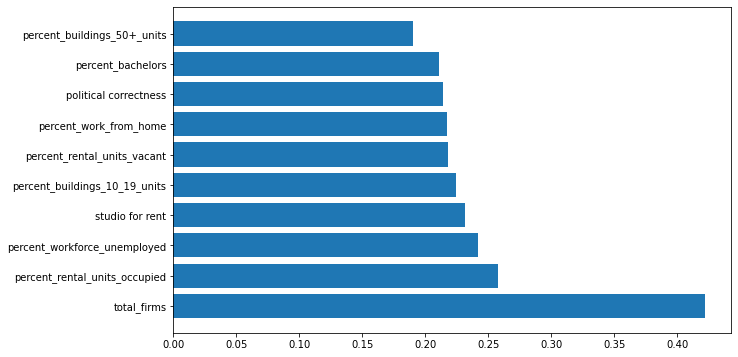


Got an mse at 0.0025 in epoch 30 and stopped training



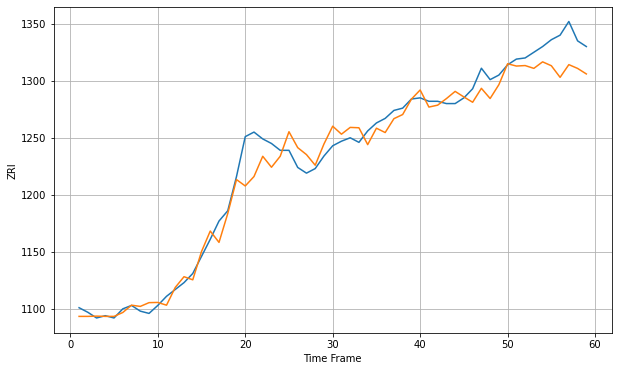

Wall time: 8.5 s
1603 12.581014137937759 20.995598534211197


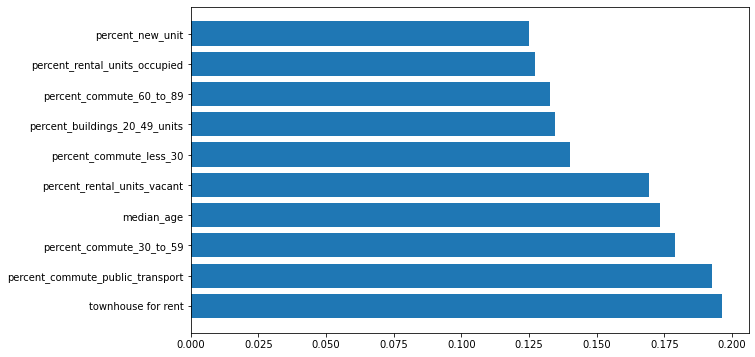


Got an mse at 0.0025 in epoch 55 and stopped training



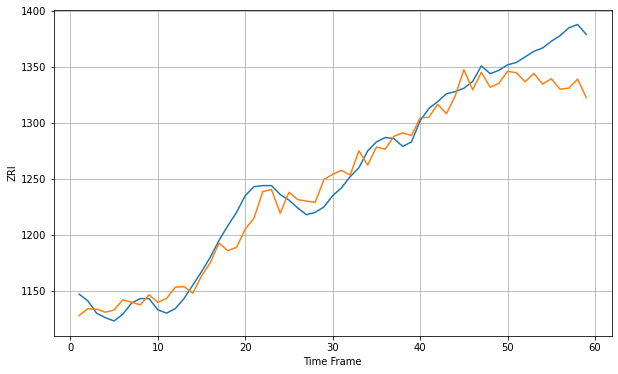

Wall time: 9.2 s
1604 13.087651994473262 34.41942240664416


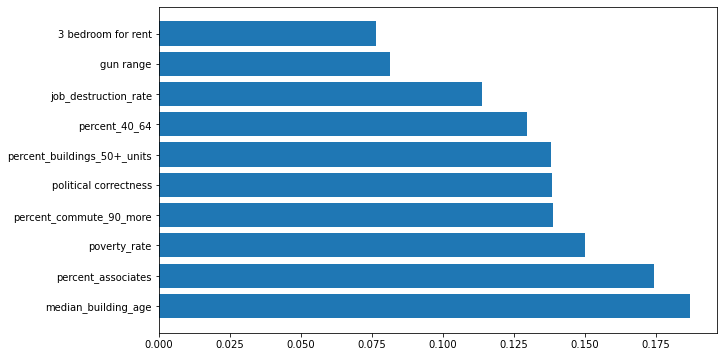


Got an mse at 0.0024 in epoch 44 and stopped training



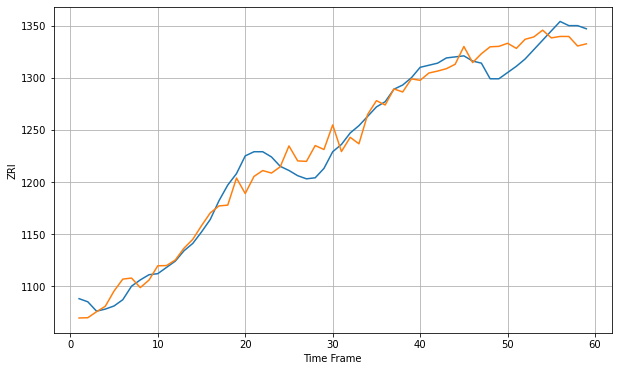

Wall time: 8.88 s
1605 13.336923130528978 19.456342774228556


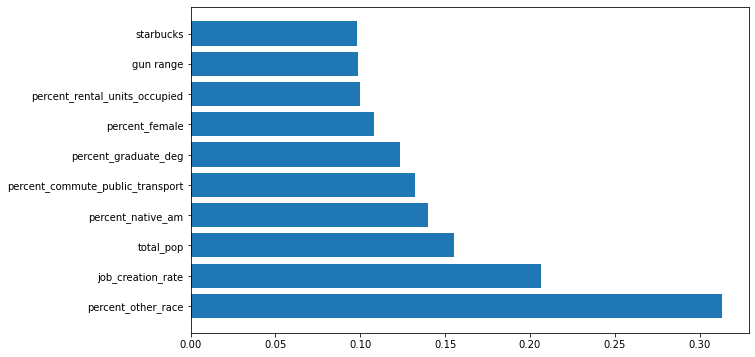


Got an mse at 0.0025 in epoch 52 and stopped training



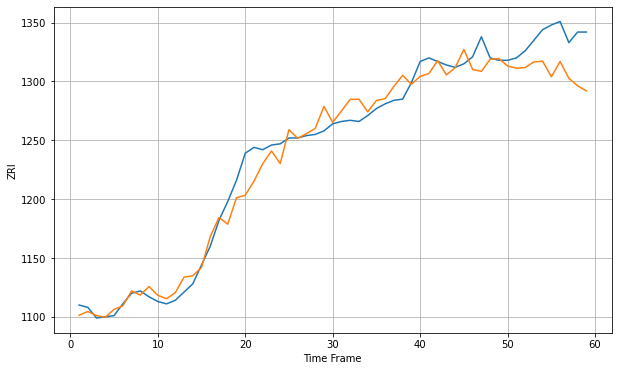

Wall time: 8.96 s
1610 12.341225171282995 28.798345988656802


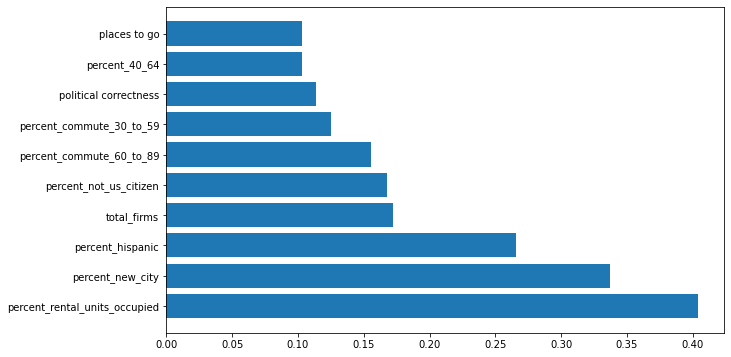


Got an mse at 0.0025 in epoch 72 and stopped training



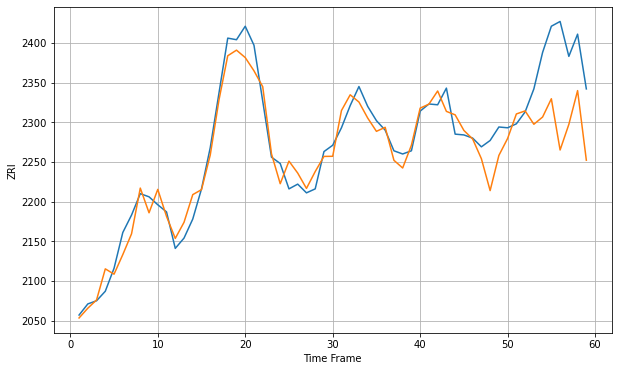

Wall time: 9.7 s
1702 17.955605907760386 75.99502915431403


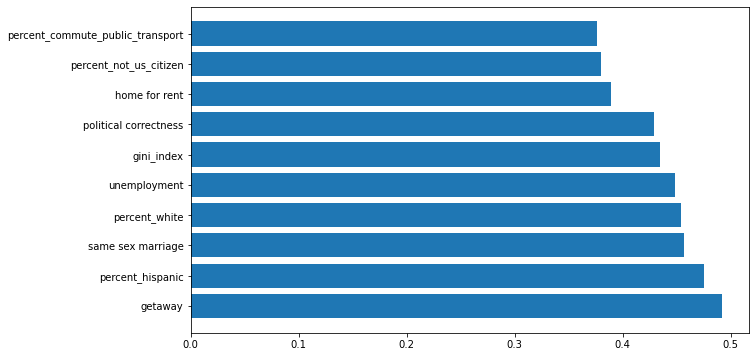


Got an mse at 0.0025 in epoch 61 and stopped training



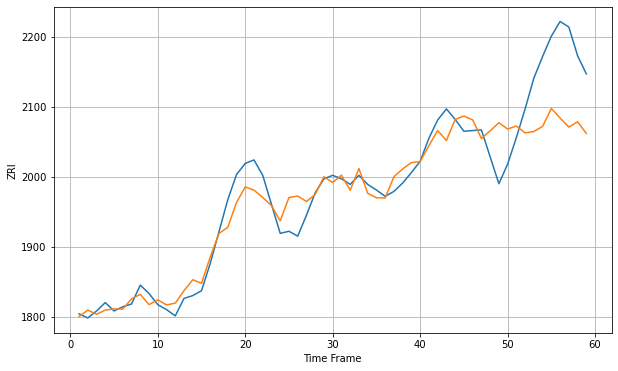

Wall time: 9.21 s
1752 20.843184897313414 89.04934686393466


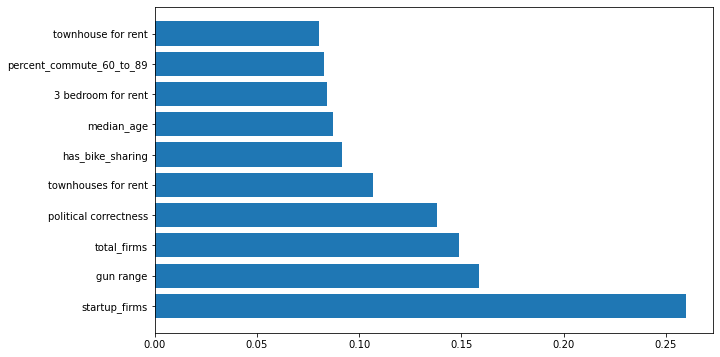


Got an mse at 0.0025 in epoch 107 and stopped training



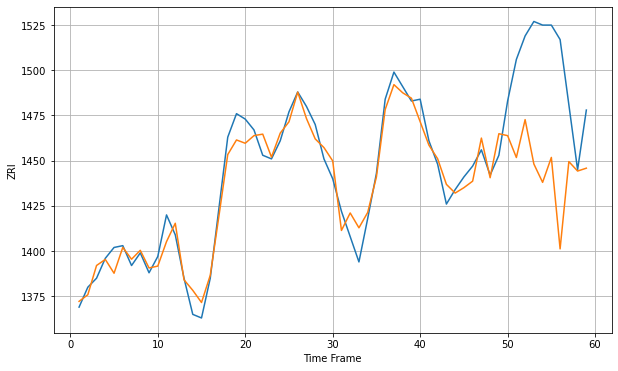

Wall time: 10.5 s
1757 7.952040271373262 57.85776078982492


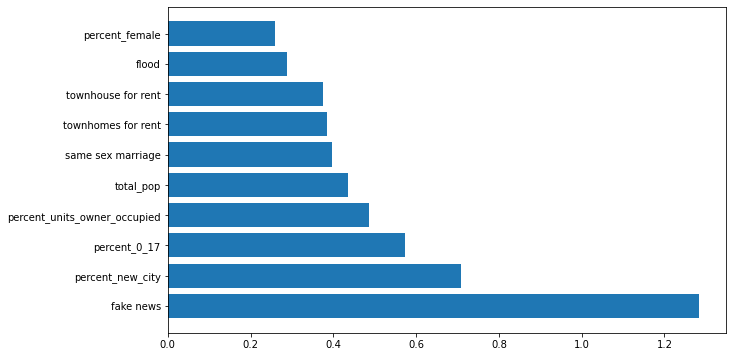


Got an mse at 0.0025 in epoch 90 and stopped training



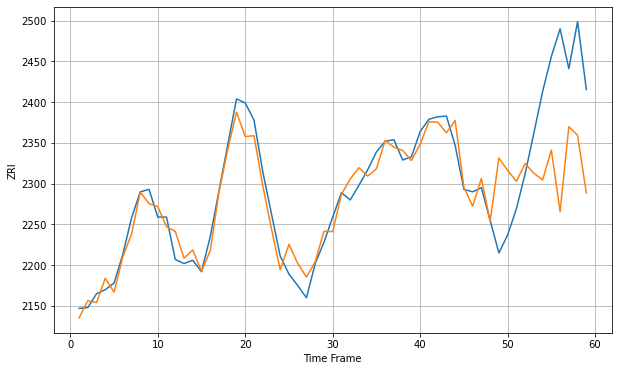

Wall time: 10.1 s
1760 17.138323531064255 107.8053236671613


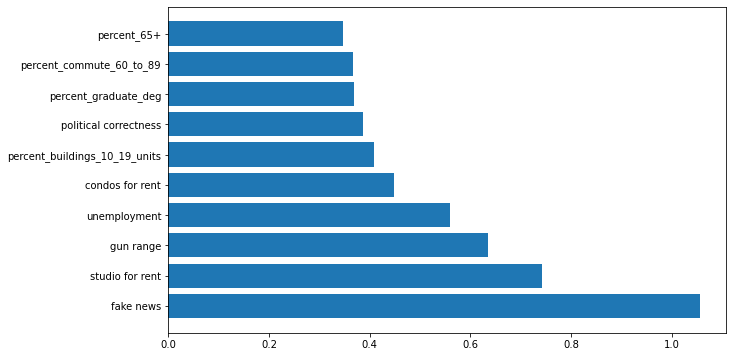


Got an mse at 0.0024 in epoch 94 and stopped training



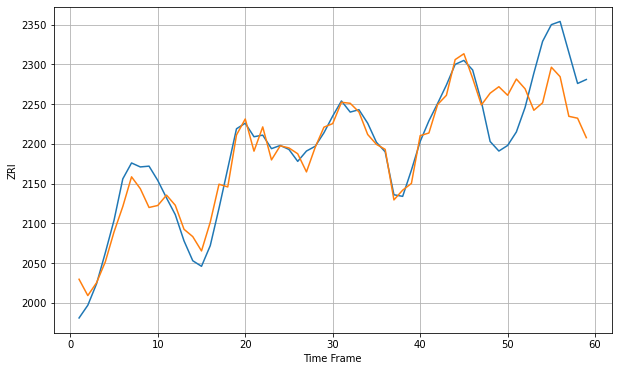

Wall time: 10.3 s
1801 18.380759189887755 63.74726269296047


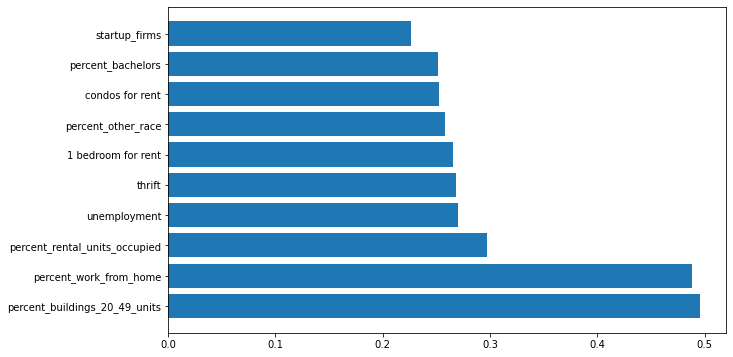


Got an mse at 0.0025 in epoch 57 and stopped training



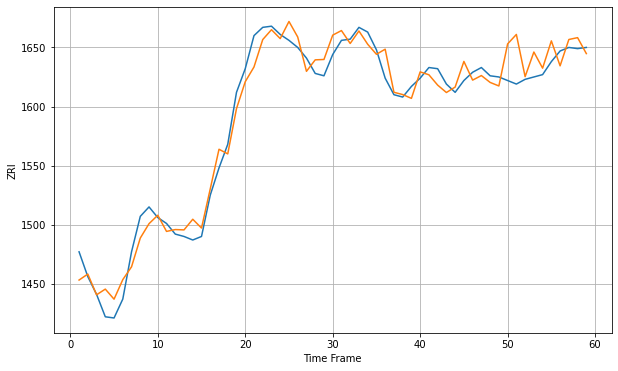

Wall time: 9.34 s
1830 12.157980078319703 18.07156933722972


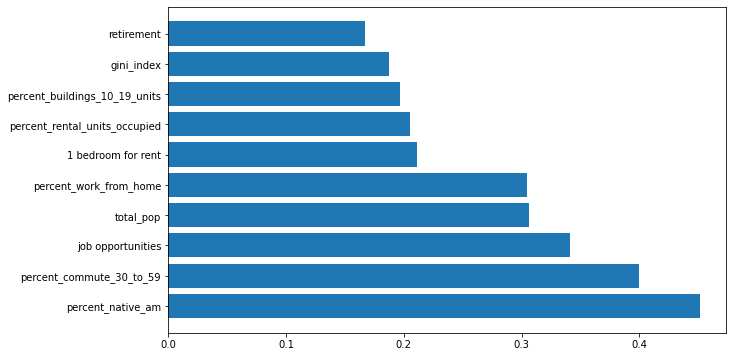


Got an mse at 0.0025 in epoch 88 and stopped training



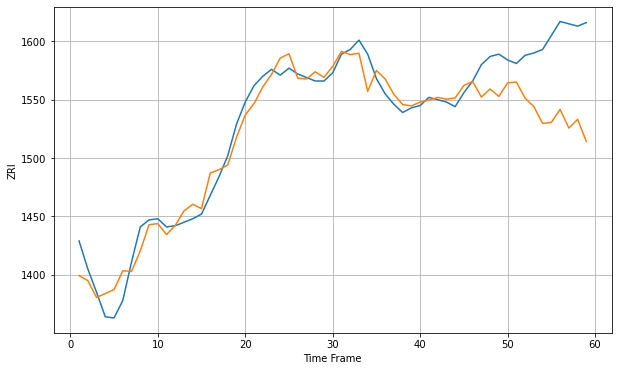

Wall time: 10.1 s
1832 12.544819424527661 62.00261660187289


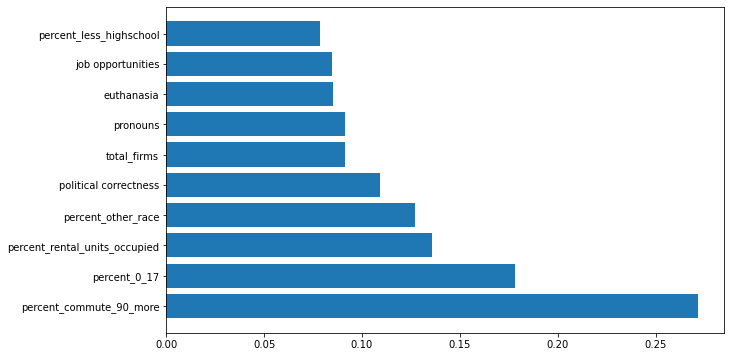


Got an mse at 0.0025 in epoch 112 and stopped training



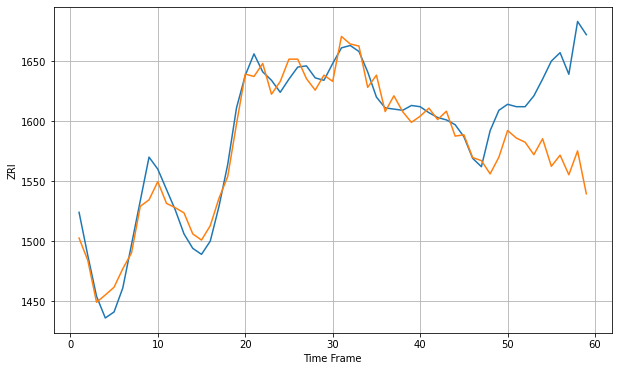

Wall time: 10.6 s
1841 12.038482863878013 71.23378412196728


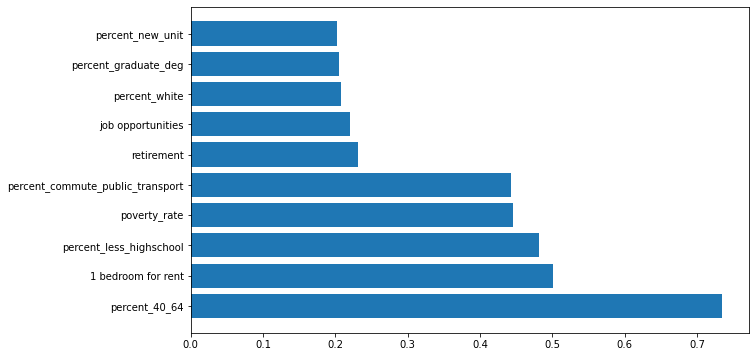


Got an mse at 0.0025 in epoch 121 and stopped training



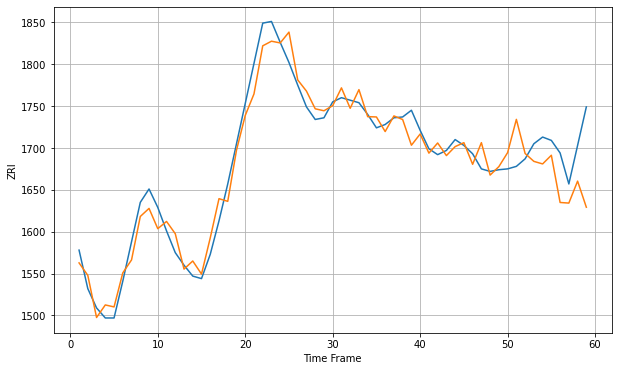

Wall time: 11 s
1843 17.51393790339627 46.157472954490444


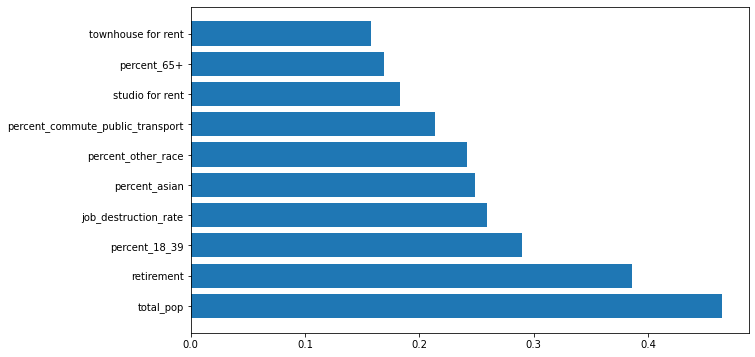


Got an mse at 0.0025 in epoch 112 and stopped training



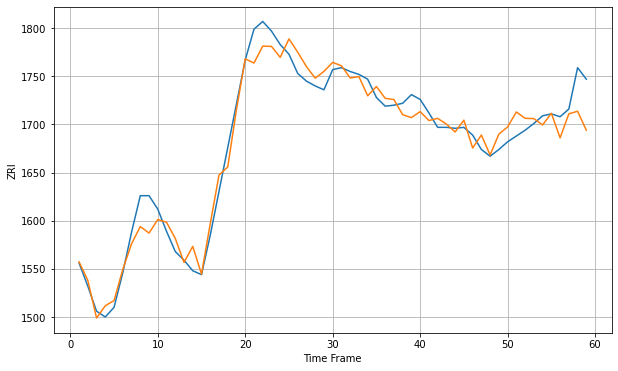

Wall time: 11.2 s
1844 15.124265293982964 23.721398736932077


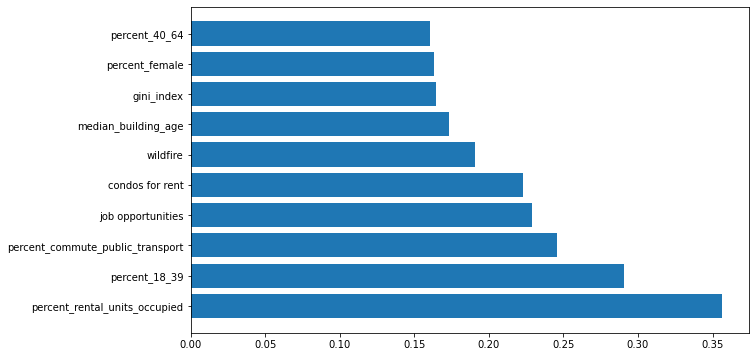


Got an mse at 0.0025 in epoch 84 and stopped training



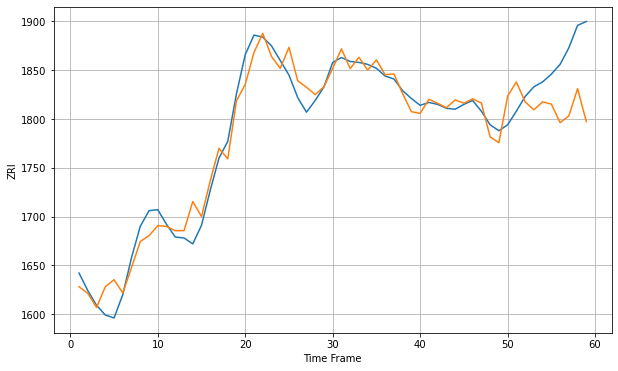

Wall time: 9.88 s
1845 14.951397428598124 47.632153562561804


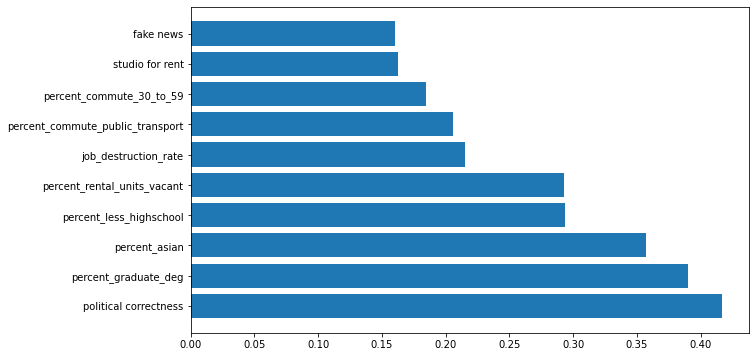


Got an mse at 0.0025 in epoch 115 and stopped training



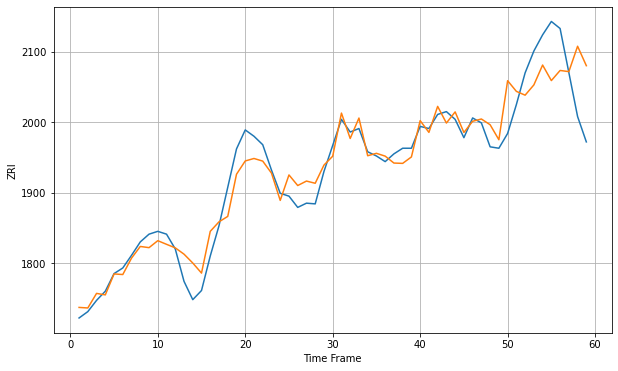

Wall time: 10.6 s
1850 20.60132858889011 60.9036435255655


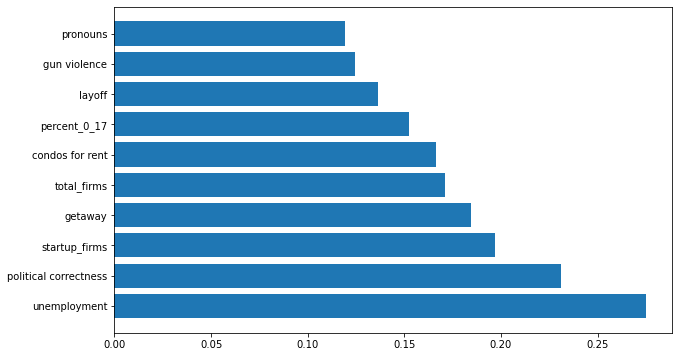


Got an mse at 0.0025 in epoch 118 and stopped training



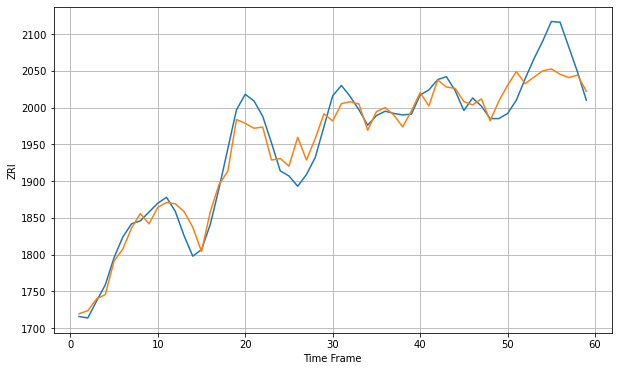

Wall time: 11.2 s
1851 19.825275485404465 37.493438985620394


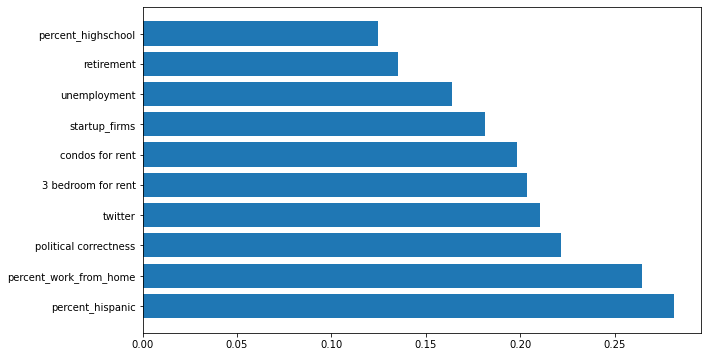


Got an mse at 0.0025 in epoch 74 and stopped training



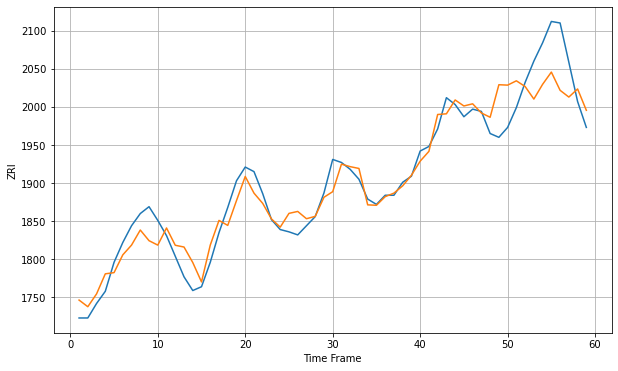

Wall time: 9.69 s
1852 19.27403043298247 50.063514564849775


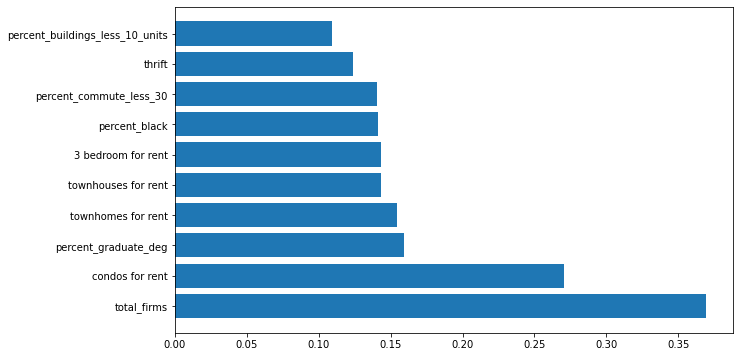


Got an mse at 0.0025 in epoch 57 and stopped training



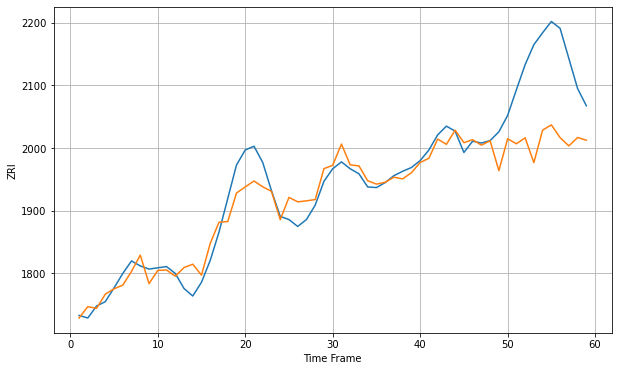

Wall time: 9.17 s
1854 23.129323836646552 119.71810333315682


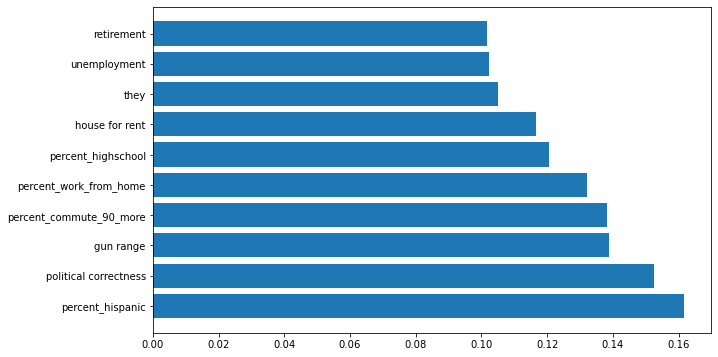


Got an mse at 0.0025 in epoch 55 and stopped training



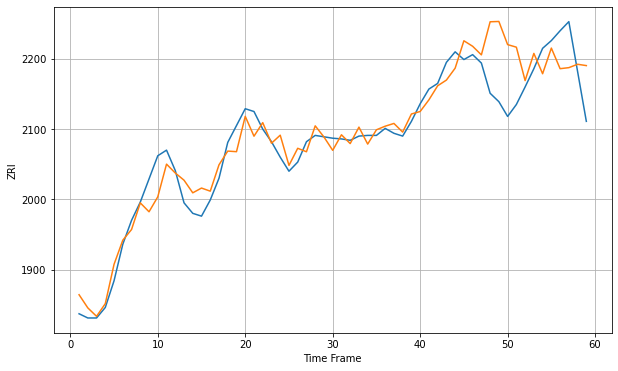

Wall time: 9.35 s
1876 20.72586887320017 68.39935447536867


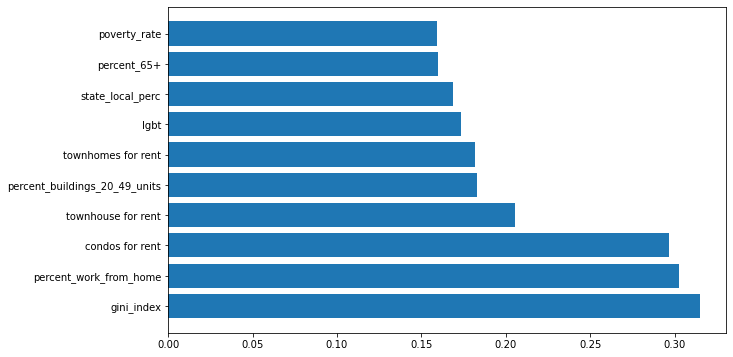


Got an mse at 0.0025 in epoch 80 and stopped training



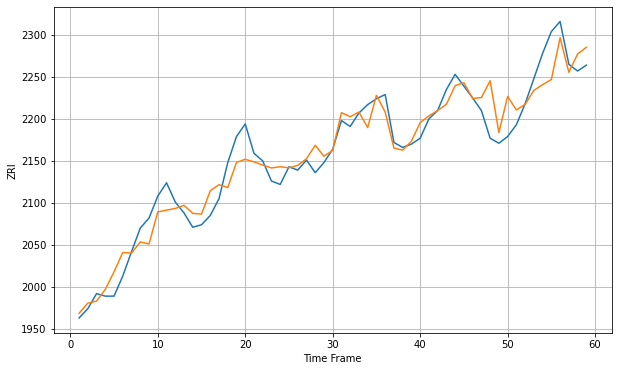

Wall time: 9.83 s
1880 17.485037248147577 33.66775830396256


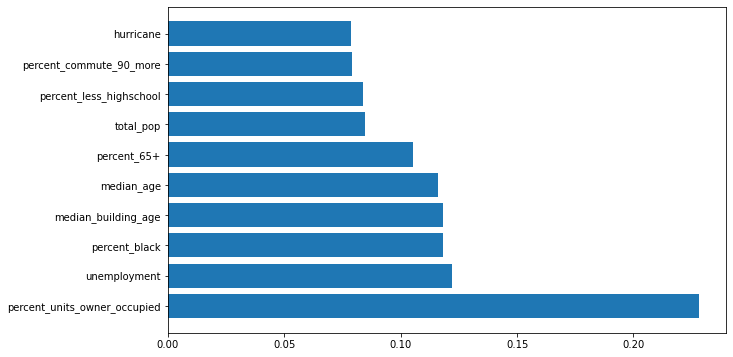


Got an mse at 0.0025 in epoch 45 and stopped training



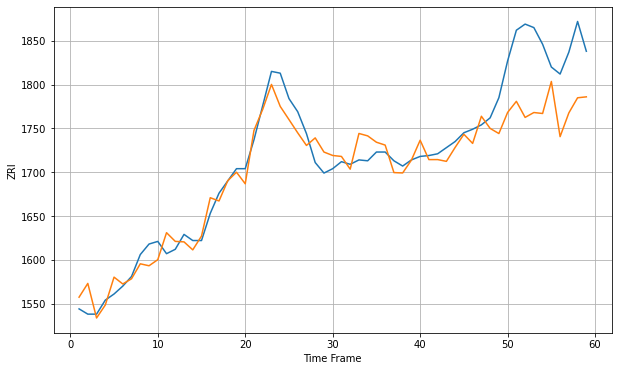

Wall time: 8.95 s
1902 16.35802670927424 70.30378306626993


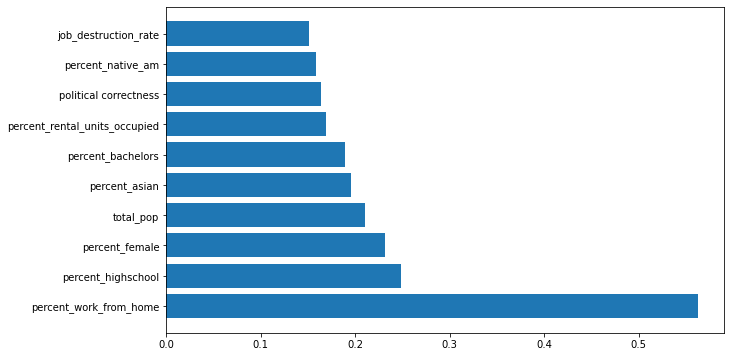


Got an mse at 0.0025 in epoch 93 and stopped training



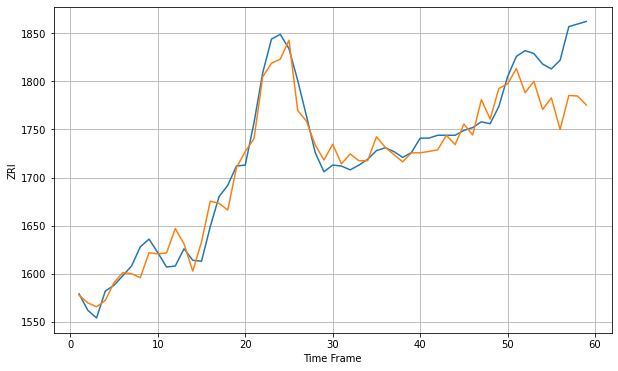

Wall time: 10.3 s
1905 15.144536822442555 49.94859524100578


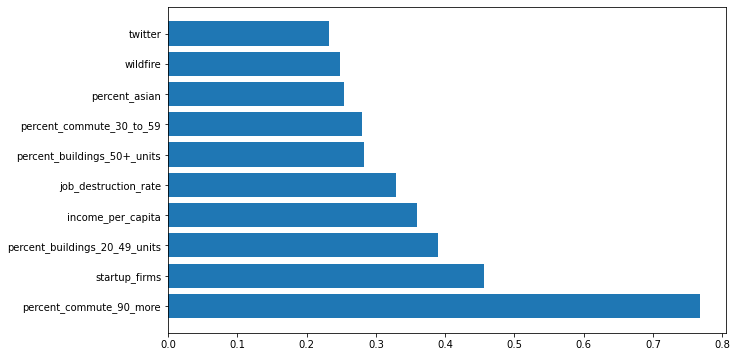


Got an mse at 0.0024 in epoch 39 and stopped training



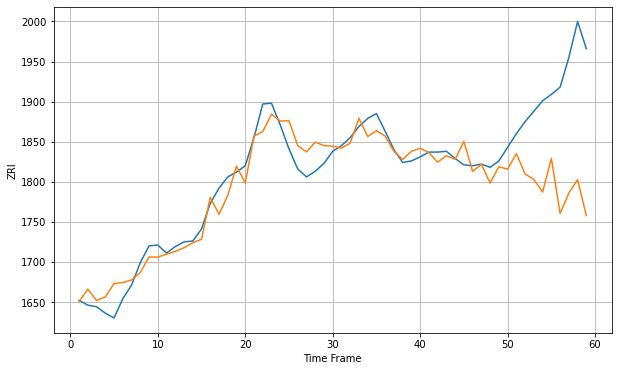

Wall time: 8.6 s
1915 17.898969604838065 118.45839937142576


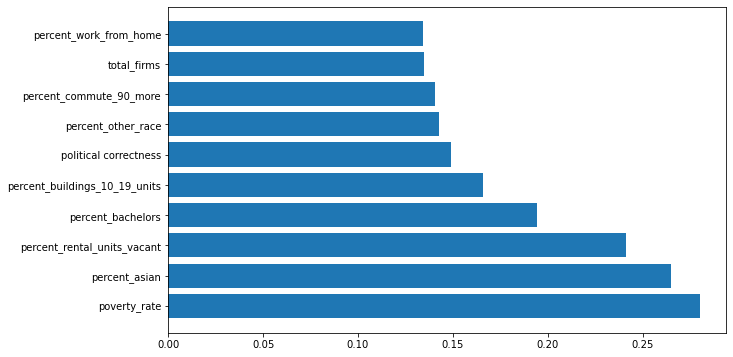


Got an mse at 0.0025 in epoch 152 and stopped training



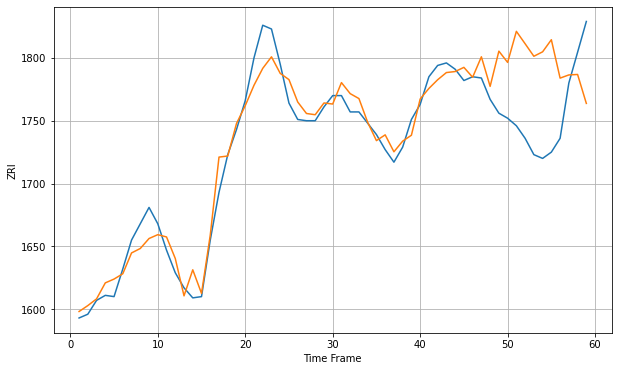

Wall time: 11.7 s
1930 12.699647194849746 60.59766892946039


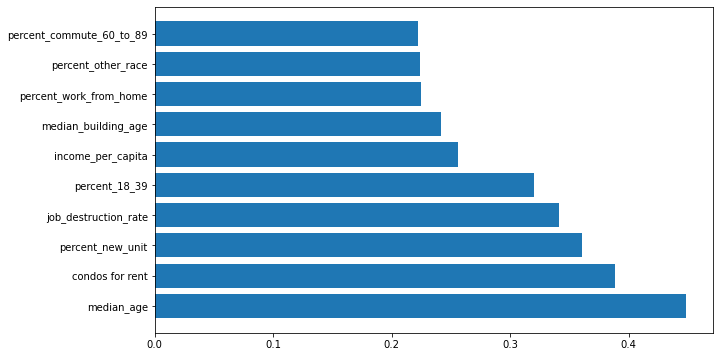


Got an mse at 0.0025 in epoch 102 and stopped training



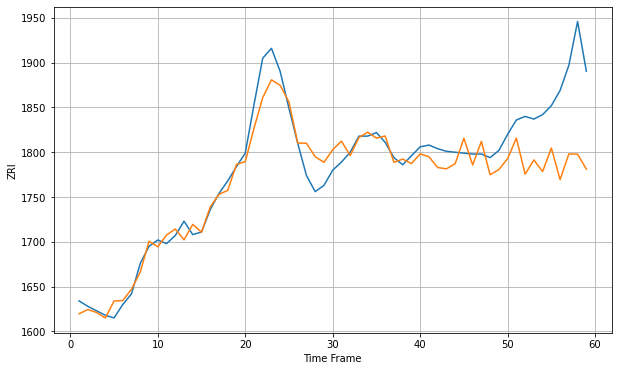

Wall time: 10.5 s
1960 16.337745773647054 75.32991868056654


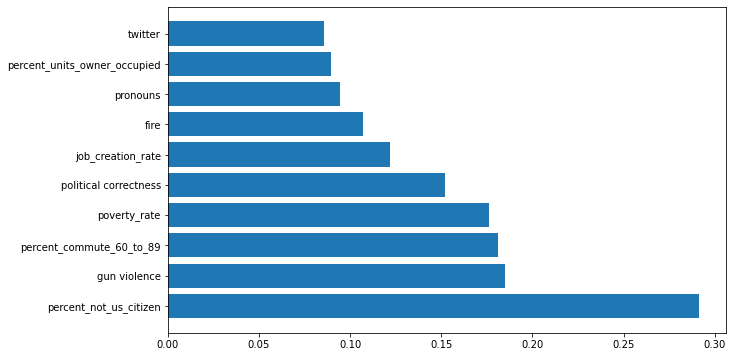


Got an mse at 0.0025 in epoch 32 and stopped training



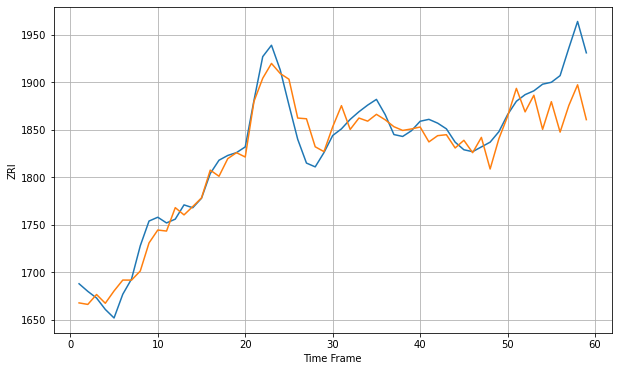

Wall time: 8.68 s
1970 15.417666338282865 41.46183016365621


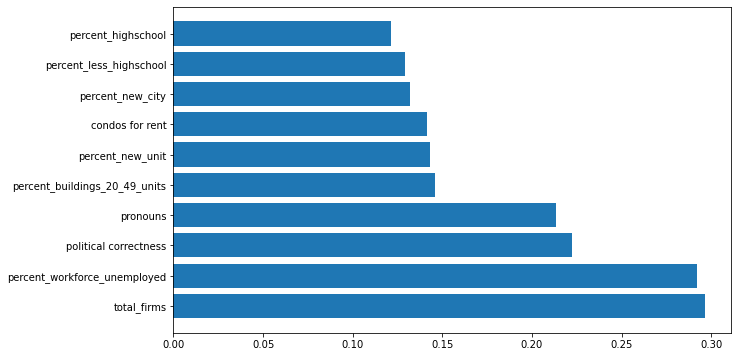


Got an mse at 0.0024 in epoch 40 and stopped training



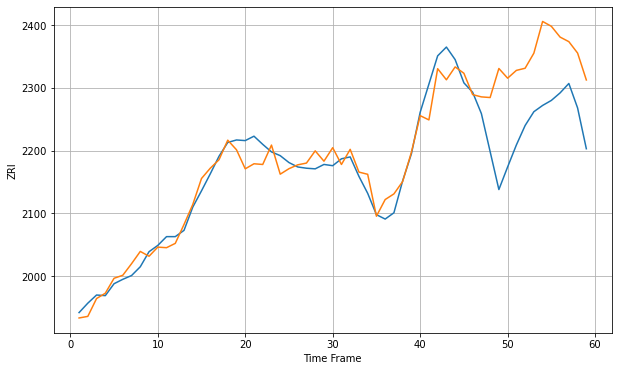

Wall time: 8.79 s
2026 21.32890801891409 115.32267806847867


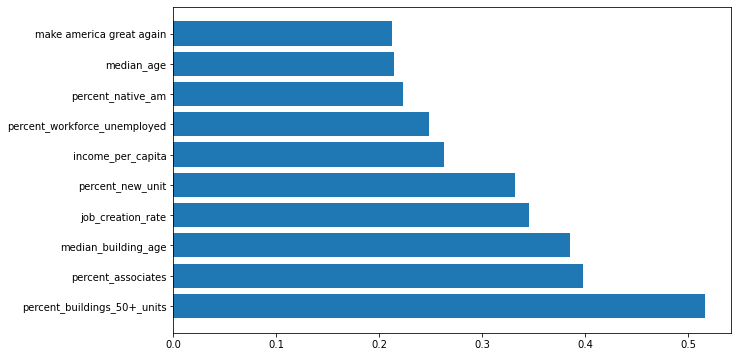


Got an mse at 0.0024 in epoch 46 and stopped training



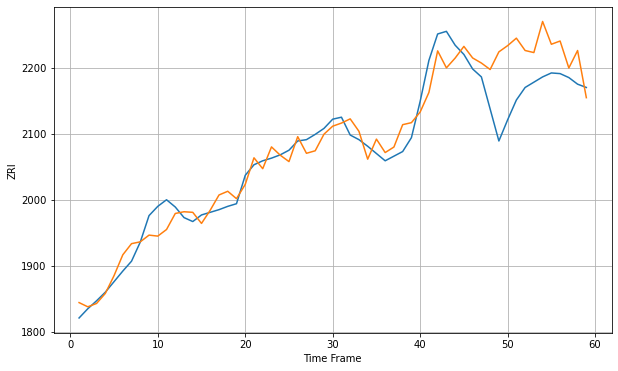

Wall time: 8.82 s
2062 21.93463867467059 72.29855662548125


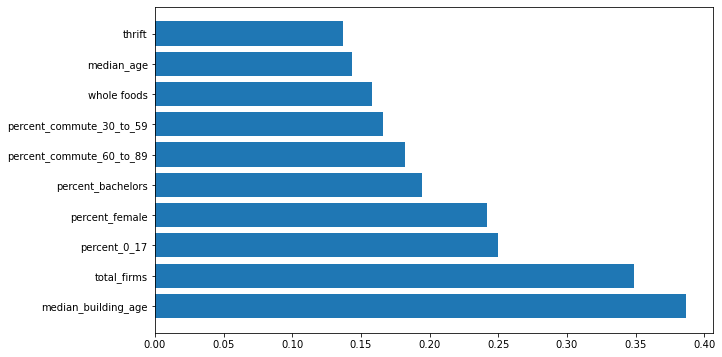


Got an mse at 0.0025 in epoch 77 and stopped training



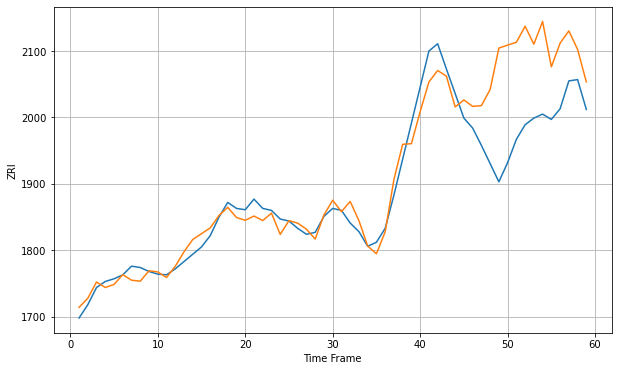

Wall time: 9.81 s
2072 20.578237424217253 124.18886233763958


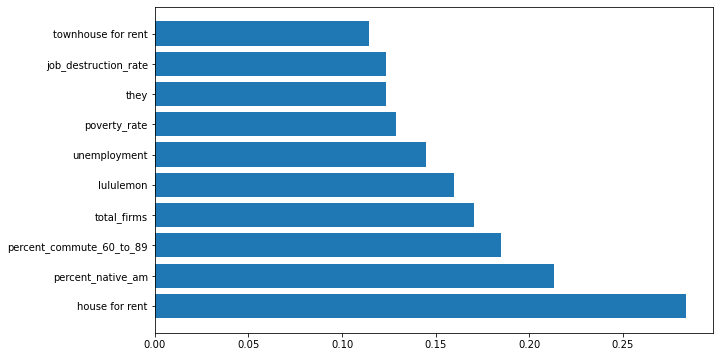


Got an mse at 0.0024 in epoch 21 and stopped training



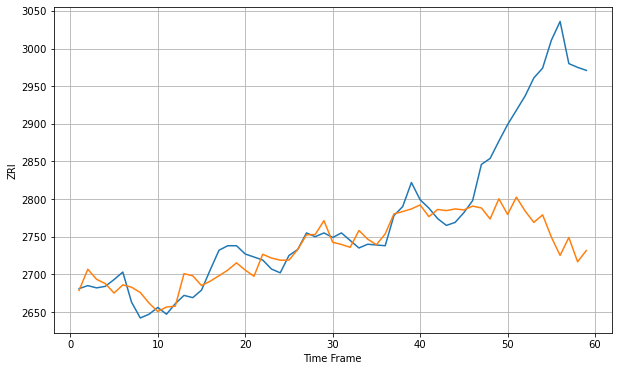

Wall time: 8.17 s
2111 18.835881462781803 200.1277848285123


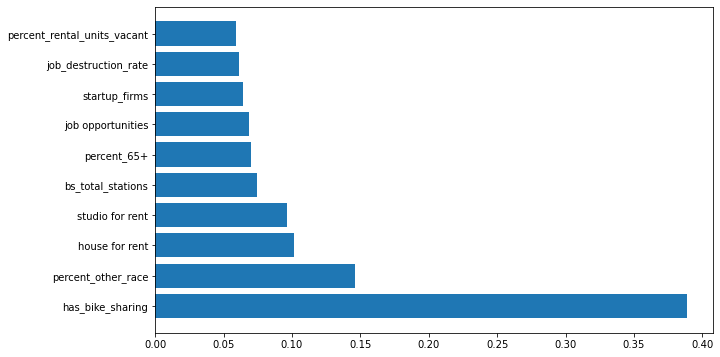


Got an mse at 0.0025 in epoch 75 and stopped training



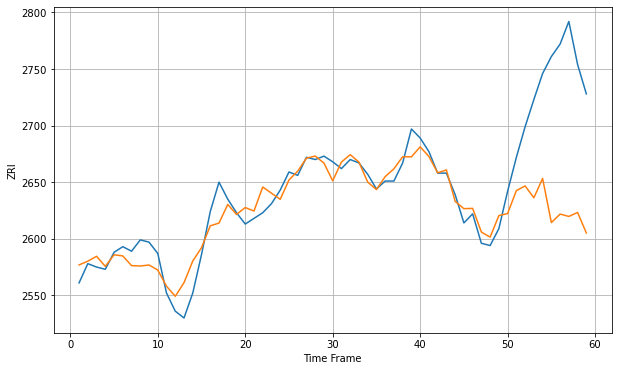

Wall time: 9.7 s
2113 12.919986251021381 102.57771491419041


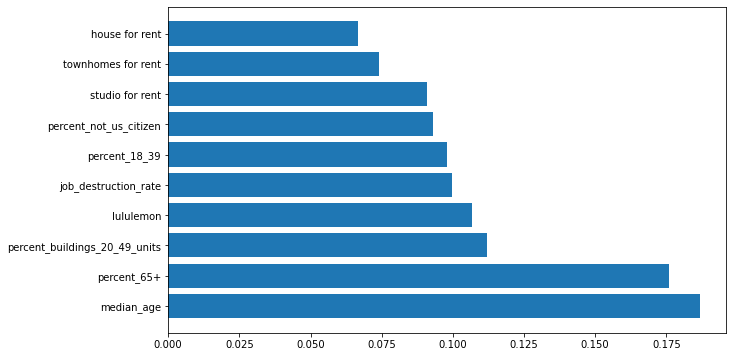


Got an mse at 0.0025 in epoch 53 and stopped training



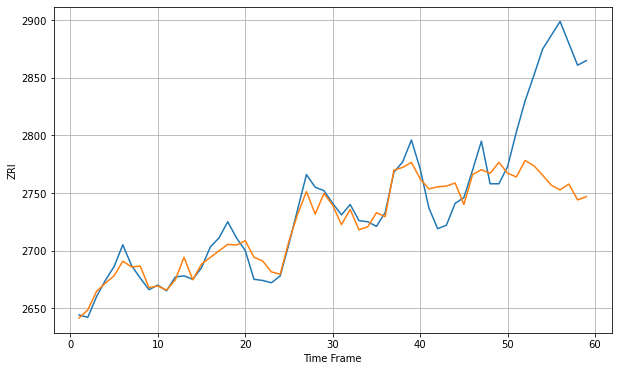

Wall time: 9.01 s
2114 12.642965031766504 92.99803297446823


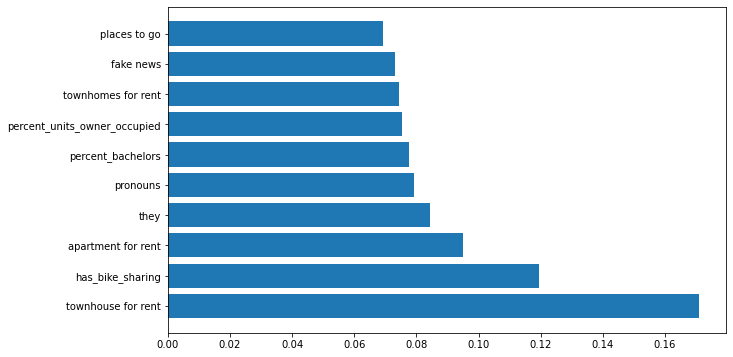


Got an mse at 0.0025 in epoch 105 and stopped training



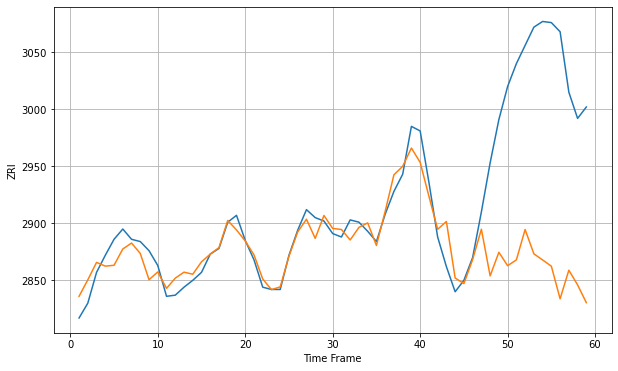

Wall time: 10.3 s
2115 12.881726486202862 173.81896539230394


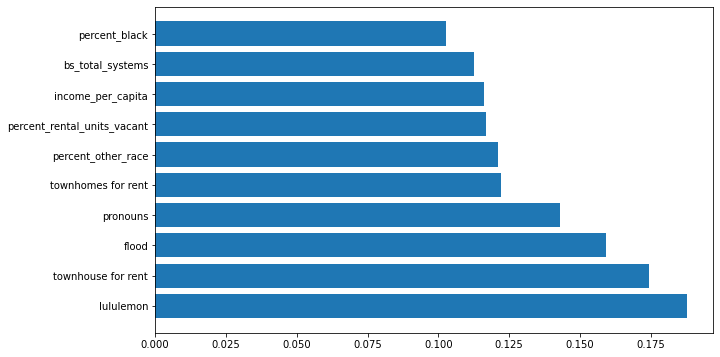


Got an mse at 0.0024 in epoch 50 and stopped training



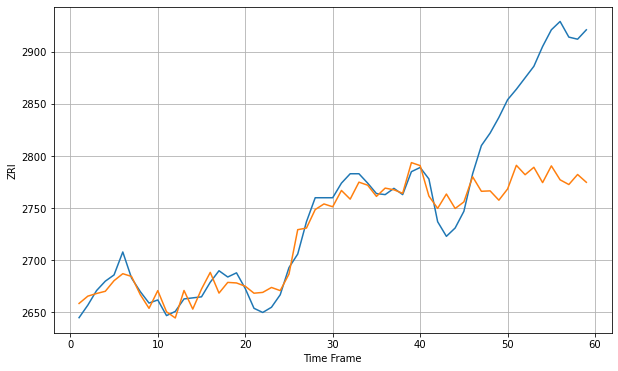

Wall time: 8.86 s
2116 13.836434949180296 113.75361054732178


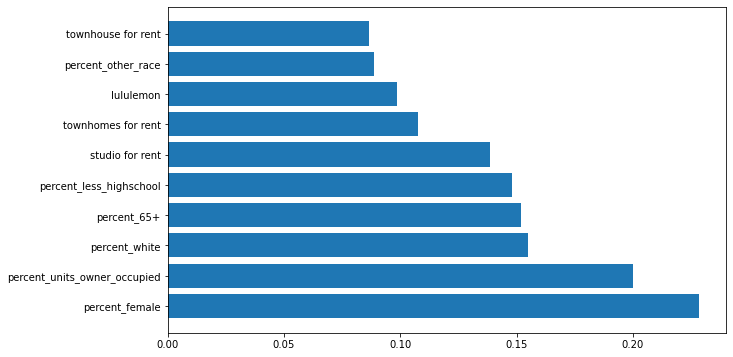


Got an mse at 0.0025 in epoch 57 and stopped training



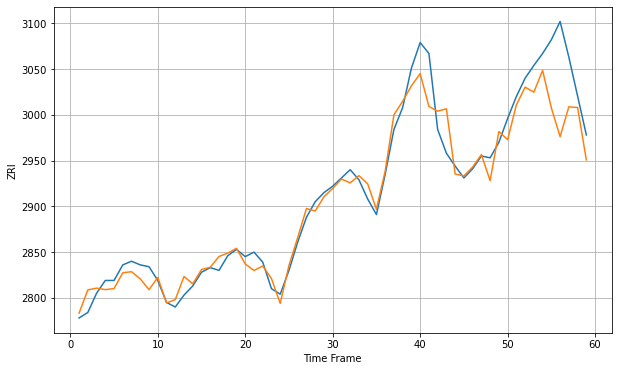

Wall time: 9.17 s
2118 16.116311333726294 48.23441023493098


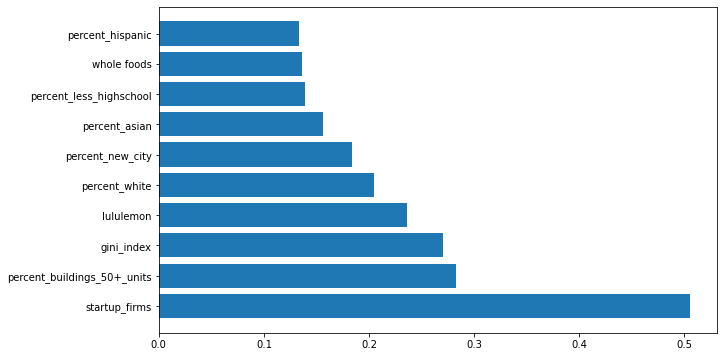


Got an mse at 0.0025 in epoch 60 and stopped training



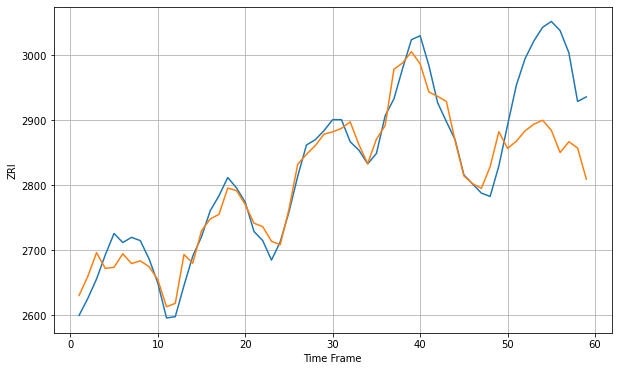

Wall time: 9.28 s
2119 23.480634289232974 117.57216221616343


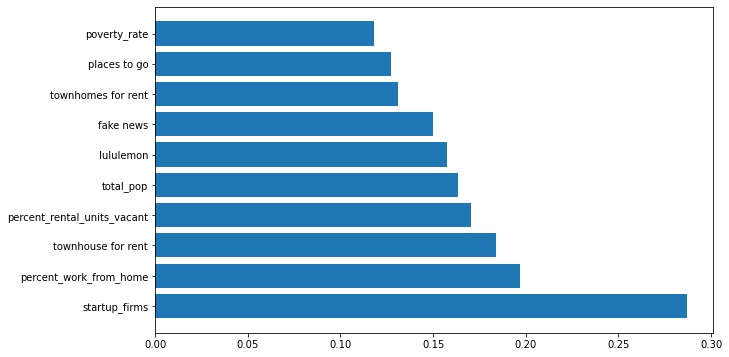


Got an mse at 0.0025 in epoch 81 and stopped training



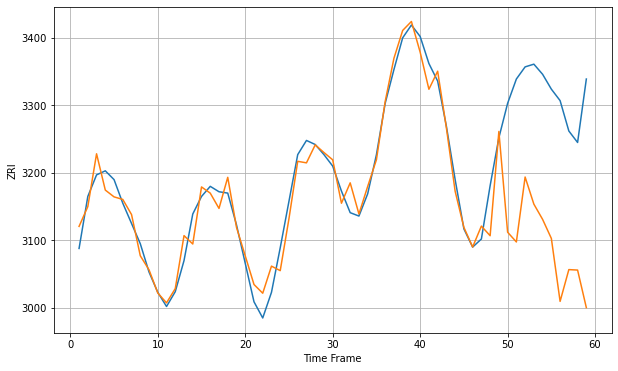

Wall time: 10.1 s
2120 21.463380130960537 213.32955984650332


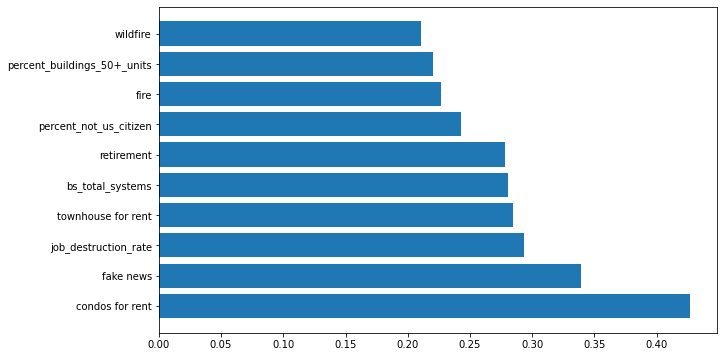


Got an mse at 0.0025 in epoch 146 and stopped training



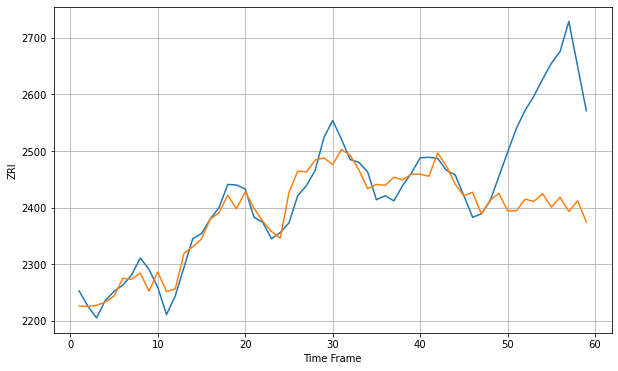

Wall time: 11.6 s
2121 25.96461777540189 198.34165231768


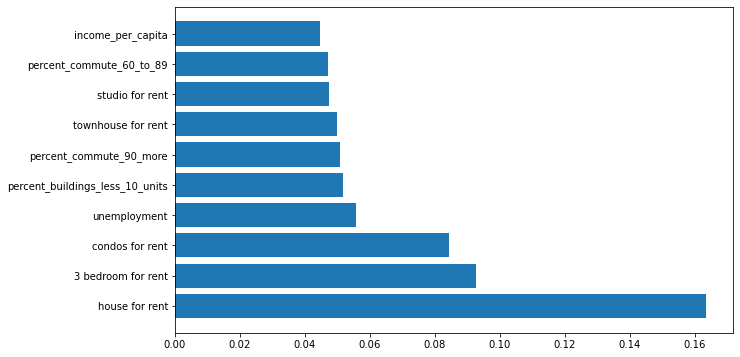


Got an mse at 0.0024 in epoch 30 and stopped training



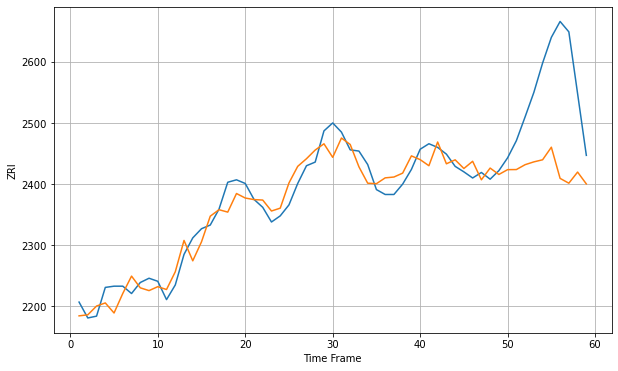

Wall time: 8.23 s
2122 23.37349381471995 136.98264346538872


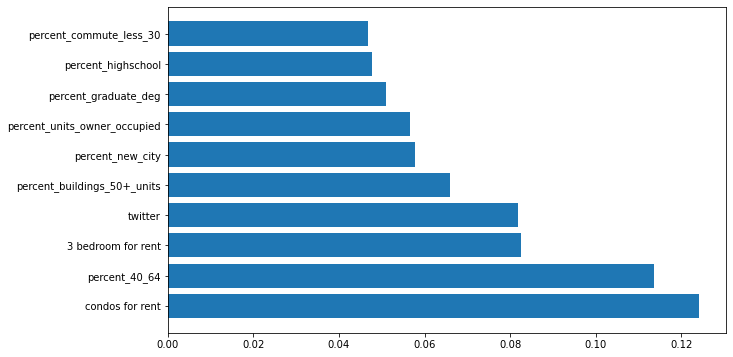


Got an mse at 0.0024 in epoch 35 and stopped training



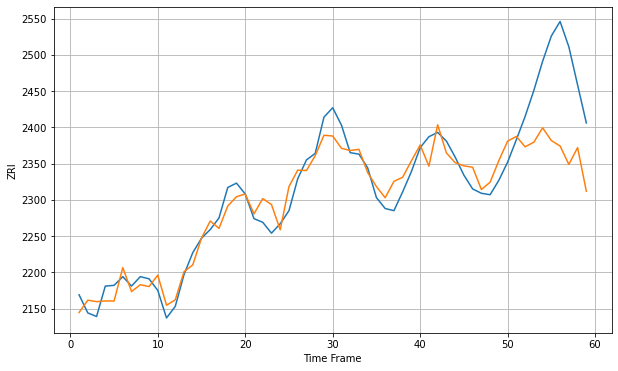

Wall time: 8.5 s
2124 19.84904739683154 95.80977104660066


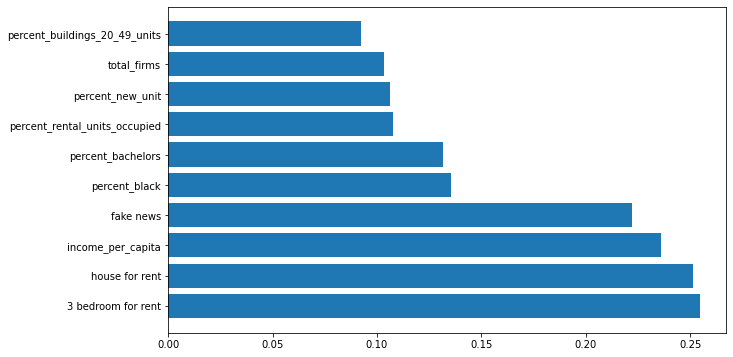


Got an mse at 0.0024 in epoch 36 and stopped training



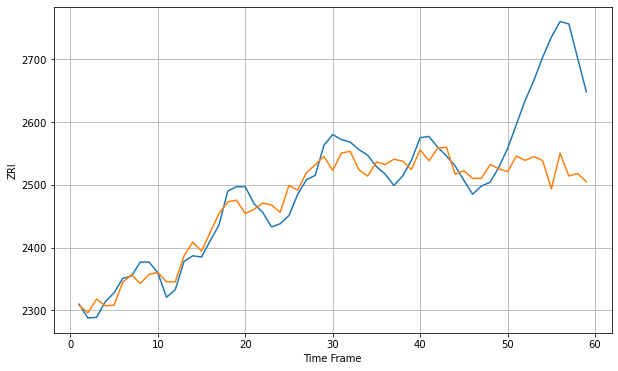

Wall time: 8.43 s
2125 22.831449711410645 150.15343407081306


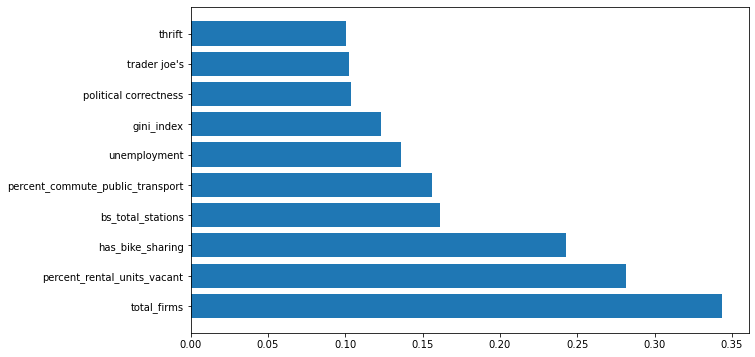


Got an mse at 0.0025 in epoch 101 and stopped training



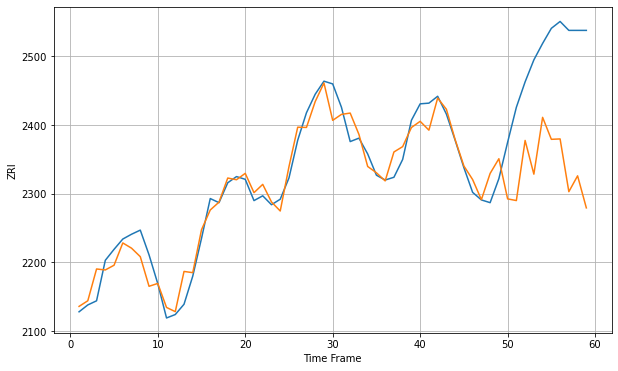

Wall time: 10.5 s
2126 21.416382991457088 157.31833405479765


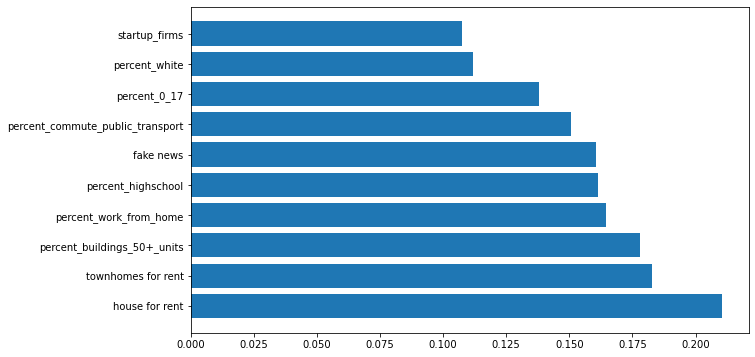


Got an mse at 0.0025 in epoch 201 and stopped training



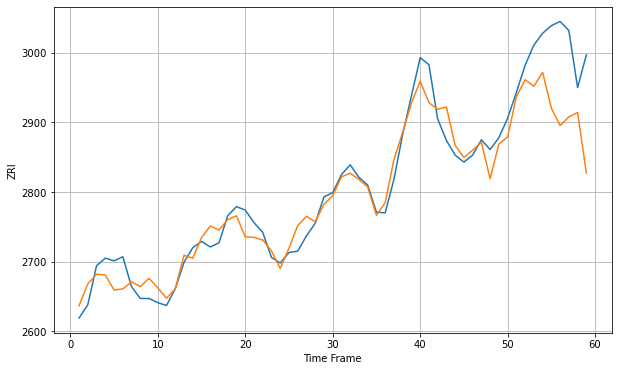

Wall time: 13.5 s
2127 21.706650475152983 87.35723442369597


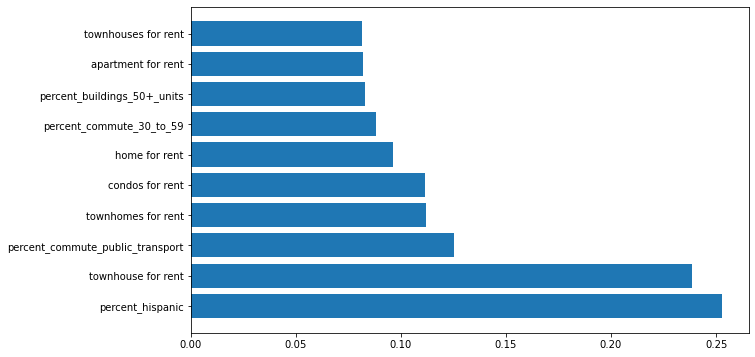


Got an mse at 0.0025 in epoch 51 and stopped training



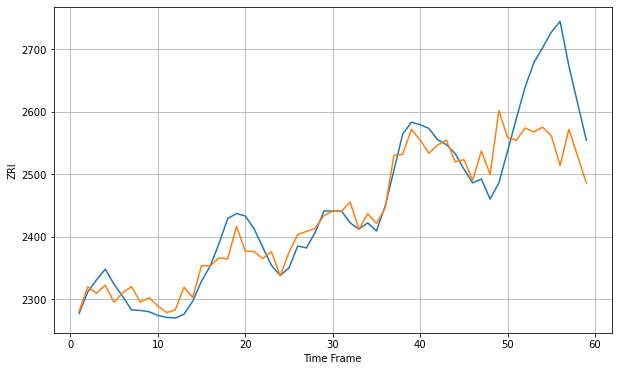

Wall time: 8.94 s
2128 24.055402424920462 112.46209004443277


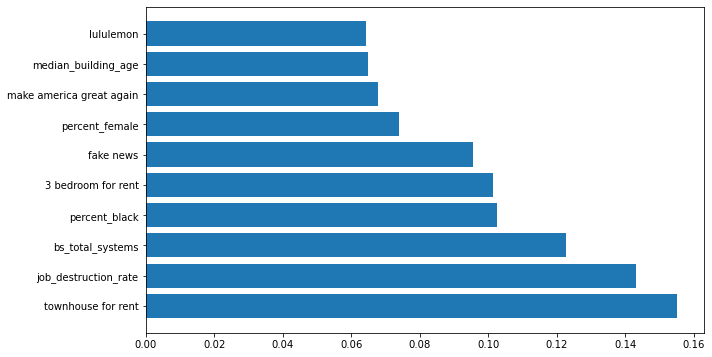


Got an mse at 0.0025 in epoch 93 and stopped training



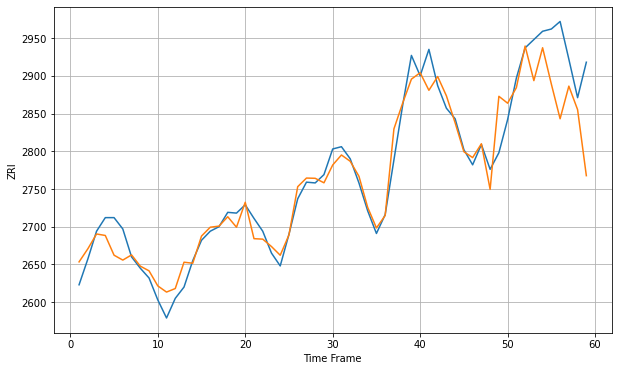

Wall time: 10.4 s
2129 19.39786982844944 68.60479439847512


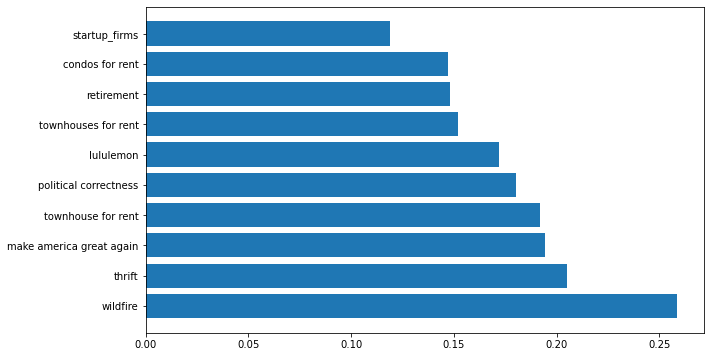


Got an mse at 0.0025 in epoch 57 and stopped training



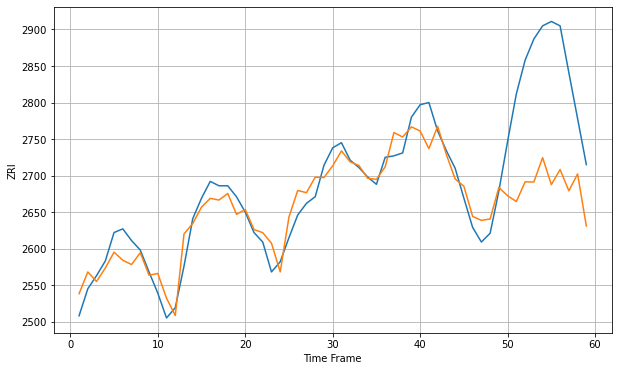

Wall time: 10 s
2130 23.172665060753662 145.5047331305116


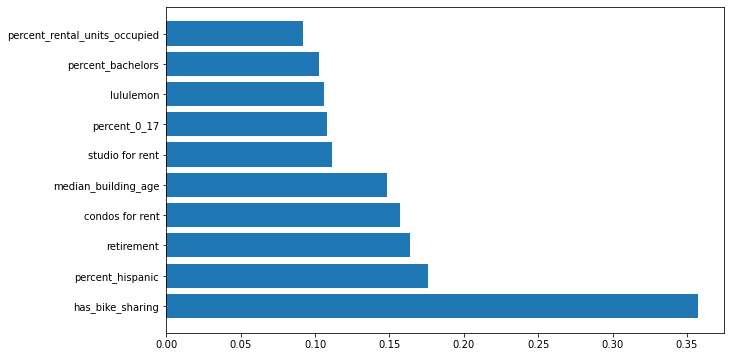


Got an mse at 0.0024 in epoch 60 and stopped training



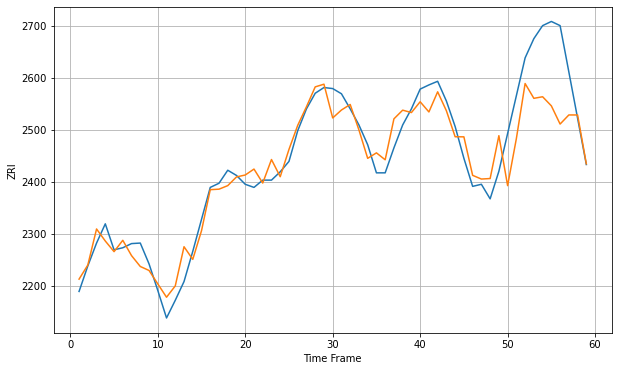

Wall time: 10 s
2131 27.65433401341302 102.61738495172277


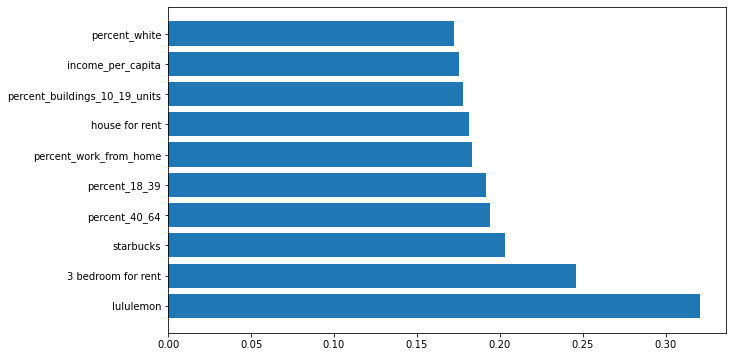


Got an mse at 0.0025 in epoch 100 and stopped training



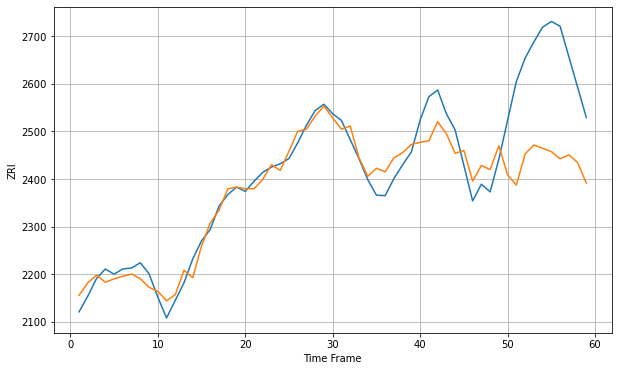

Wall time: 11.1 s
2132 30.867564362176463 194.65903987832186


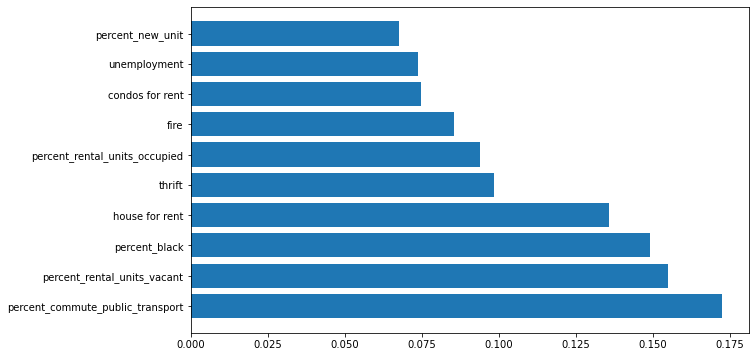


Got an mse at 0.0025 in epoch 178 and stopped training



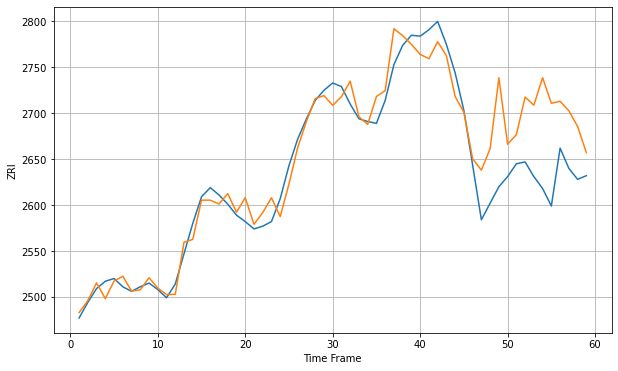

Wall time: 14.6 s
2134 17.18597155090641 75.54661009325153


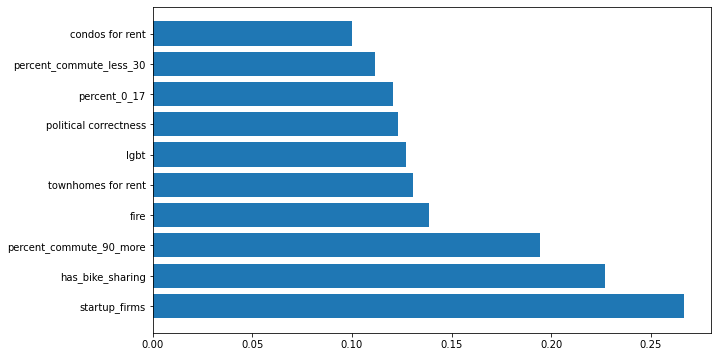


Got an mse at 0.0025 in epoch 53 and stopped training



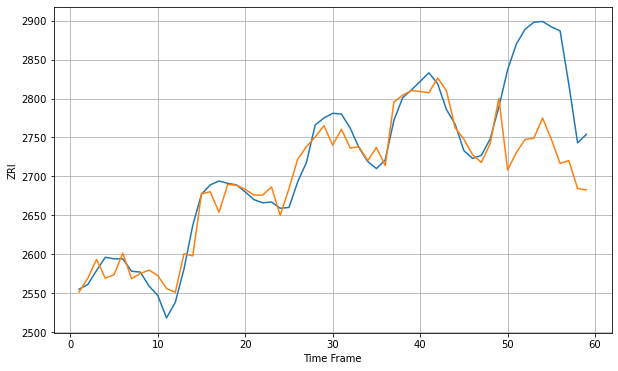

Wall time: 11.9 s
2135 18.742197420344016 116.15793323204211


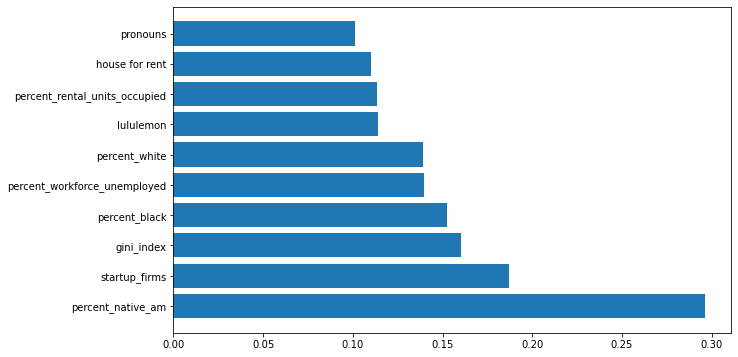


Got an mse at 0.0025 in epoch 91 and stopped training



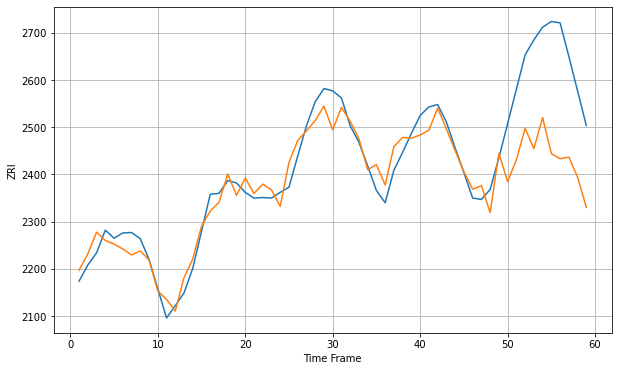

Wall time: 11.6 s
2136 30.7798298175484 187.90813190689113


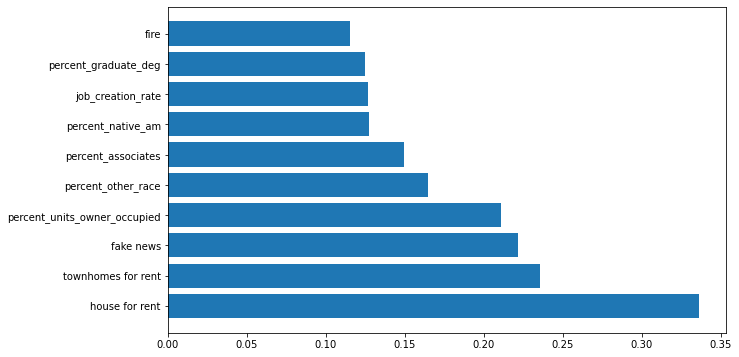


Got an mse at 0.0025 in epoch 190 and stopped training



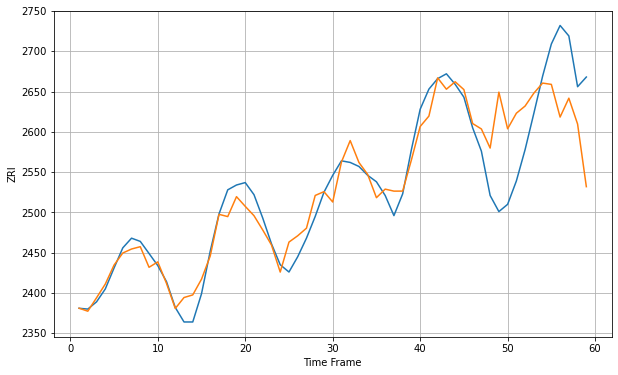

Wall time: 14.4 s
2138 18.09037740961692 85.1420178123515


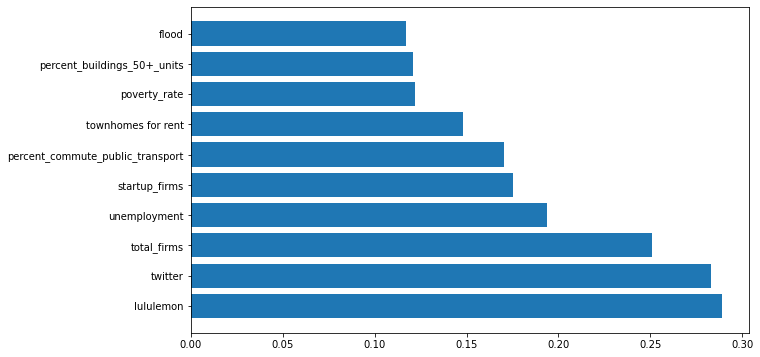


Got an mse at 0.0024 in epoch 76 and stopped training



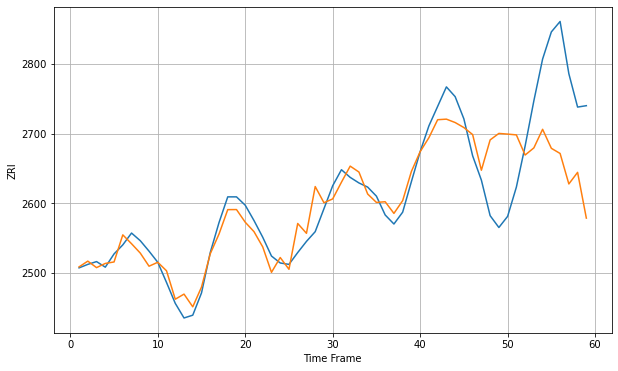

Wall time: 10.3 s
2139 20.588846719114944 125.35753416109776


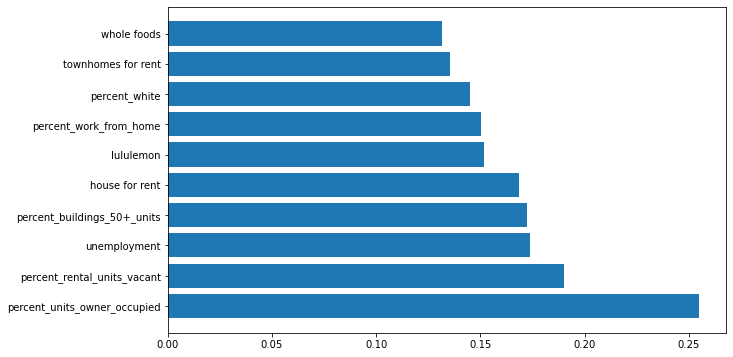


Got an mse at 0.0025 in epoch 147 and stopped training



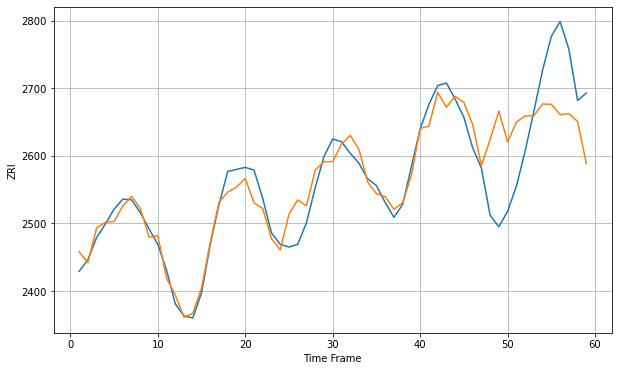

Wall time: 12.1 s
2140 21.605589507366815 98.72481099240758


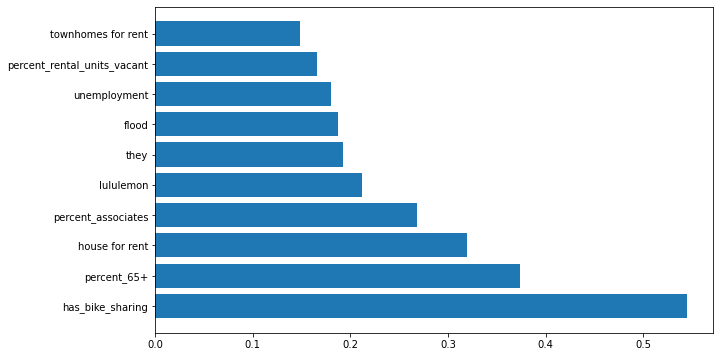


Got an mse at 0.0023 in epoch 37 and stopped training



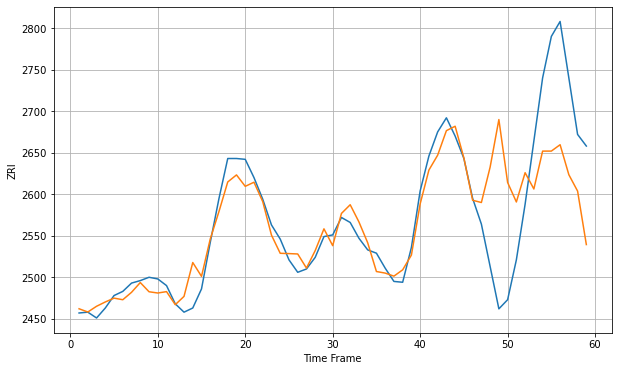

Wall time: 9.07 s
2141 16.495906642094628 121.42382300534473


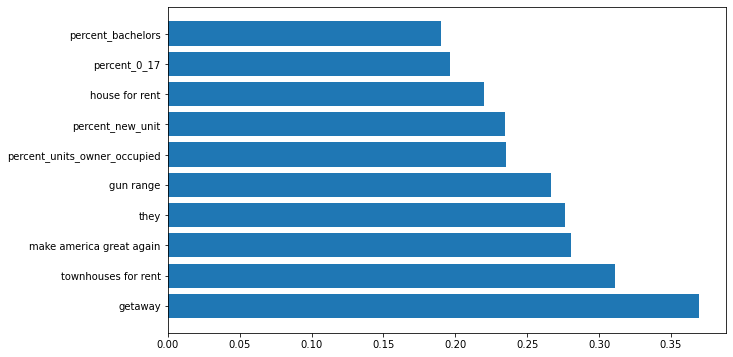


Got an mse at 0.0024 in epoch 110 and stopped training



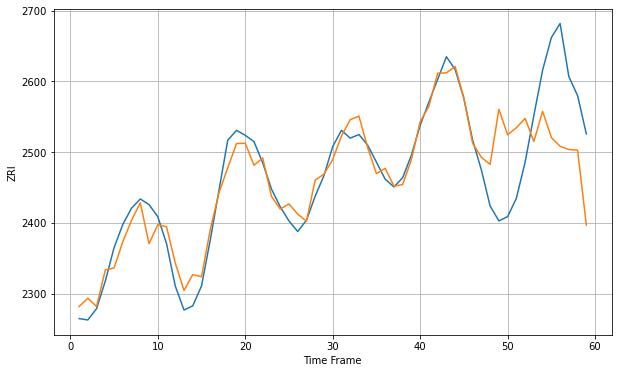

Wall time: 11 s
2143 20.384038977187426 109.33339619773083


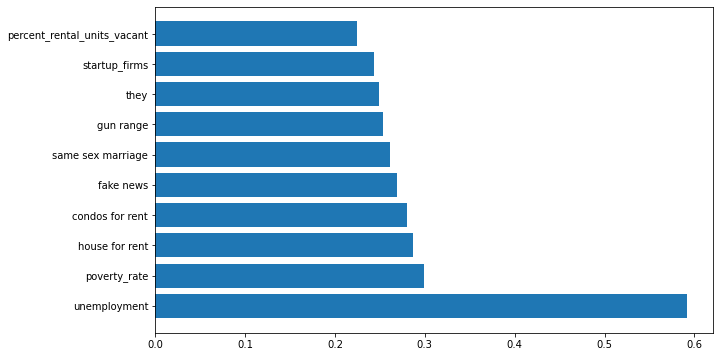


Got an mse at 0.0025 in epoch 104 and stopped training



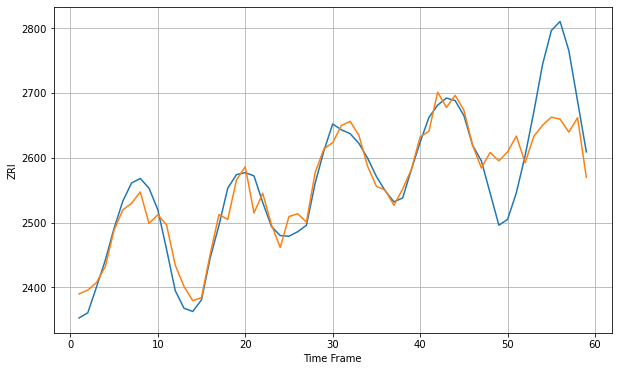

Wall time: 11 s
2144 22.445413361366118 91.76749422900352


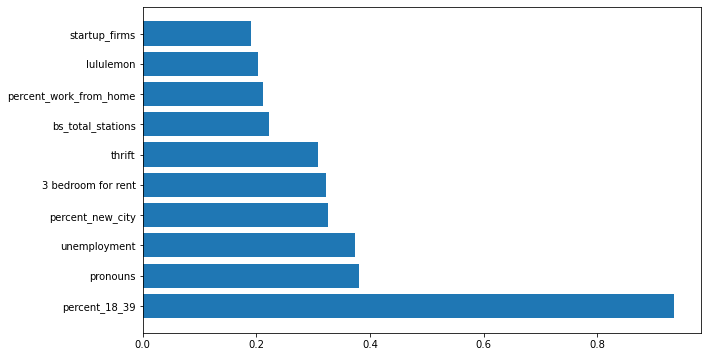


Got an mse at 0.0025 in epoch 69 and stopped training



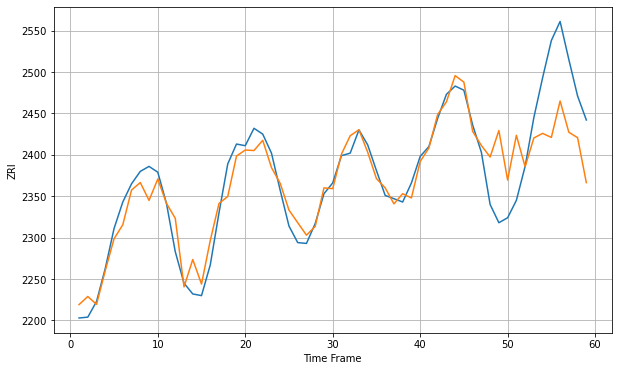

Wall time: 9.57 s
2145 17.35255344819695 75.22654365086272


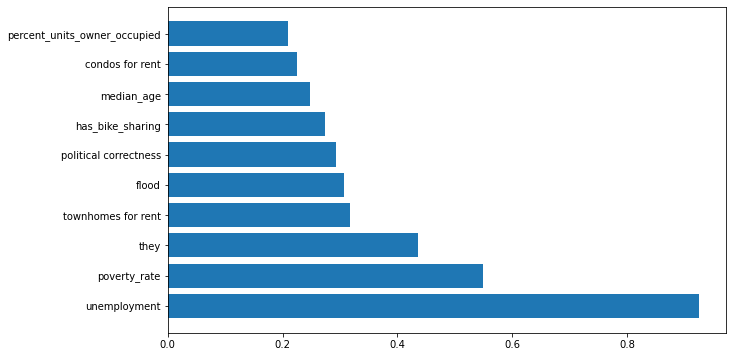


Got an mse at 0.0025 in epoch 73 and stopped training



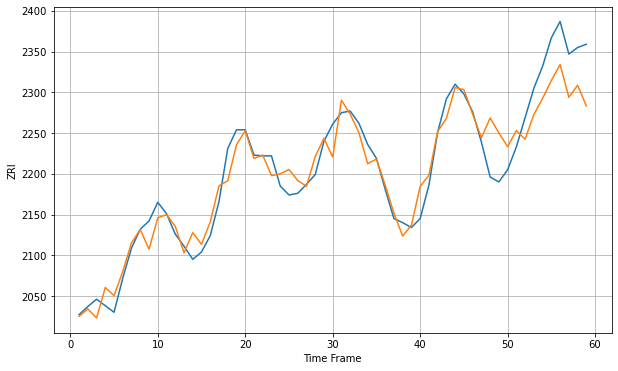

Wall time: 10.2 s
2148 17.78715986422788 49.684101361908006


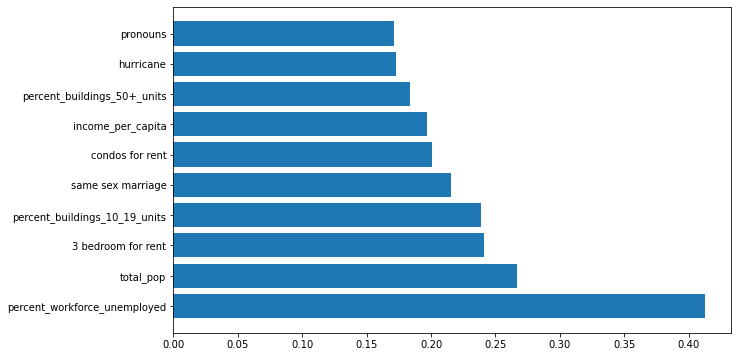


Got an mse at 0.0025 in epoch 108 and stopped training



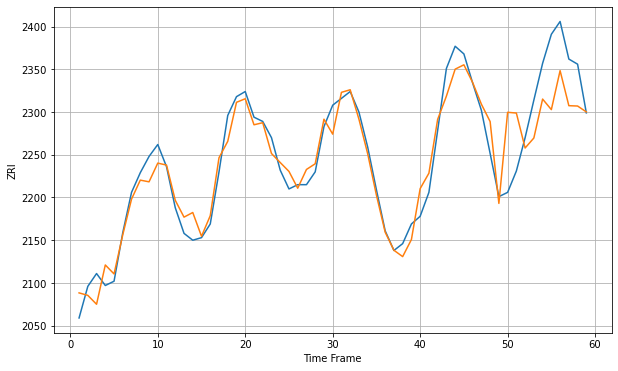

Wall time: 11.4 s
2149 17.485109508578127 54.1315779471421


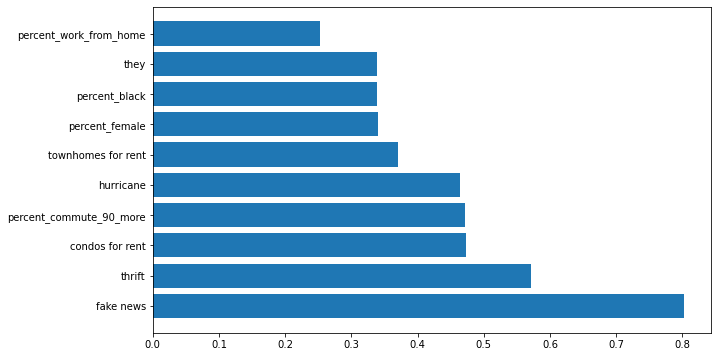


Got an mse at 0.0024 in epoch 60 and stopped training



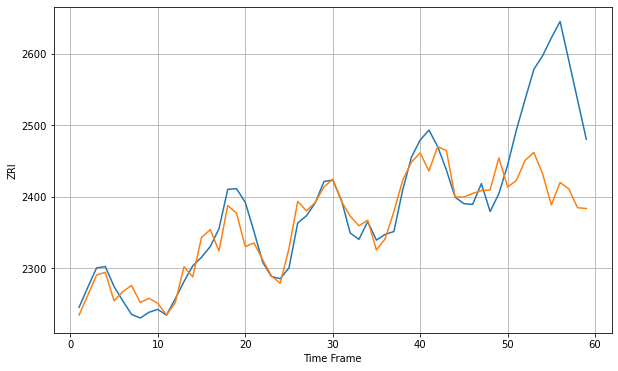

Wall time: 10.7 s
2150 21.179695560959328 137.55895683097685


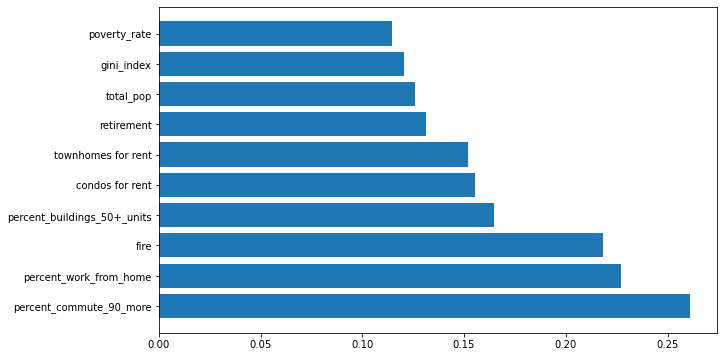


Got an mse at 0.0025 in epoch 69 and stopped training



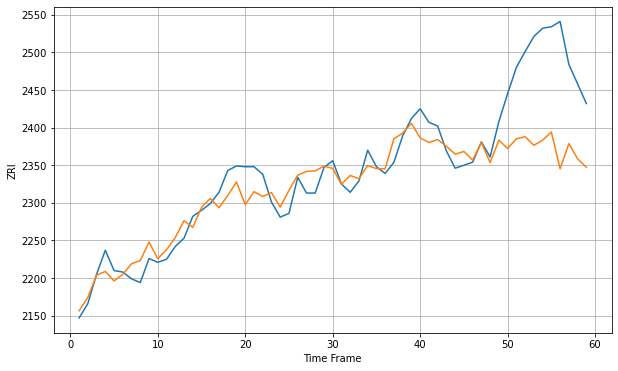

Wall time: 10.1 s
2151 20.046015903089774 114.33095109583304


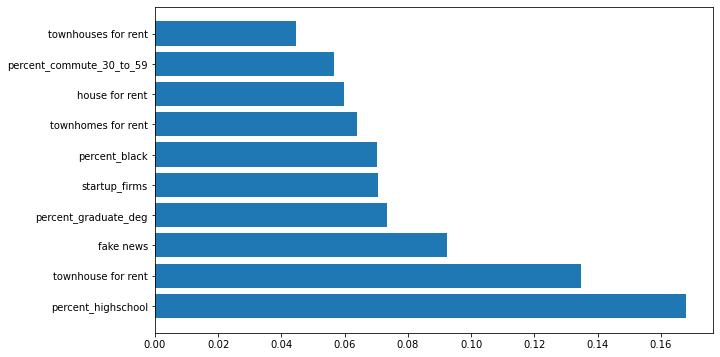


Got an mse at 0.0025 in epoch 52 and stopped training



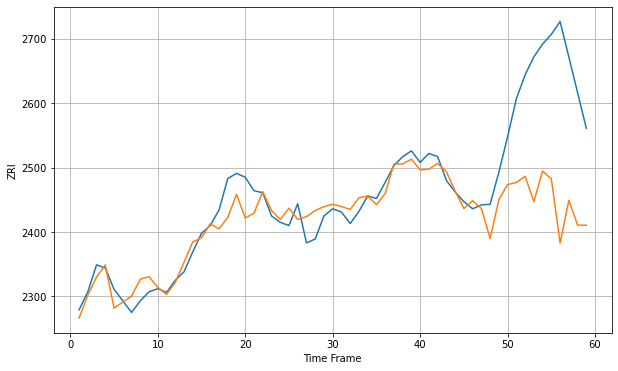

Wall time: 9.81 s
2152 22.322761050359183 188.1685076527991


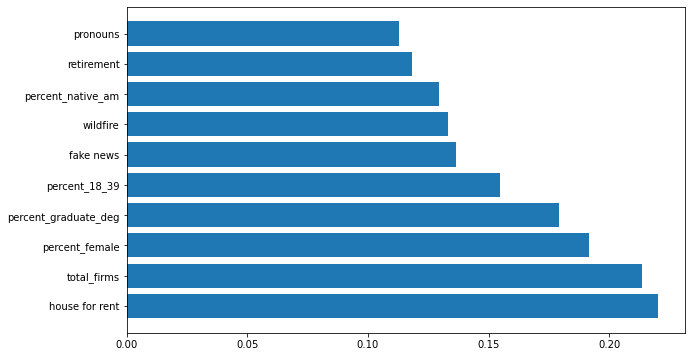


Got an mse at 0.0025 in epoch 138 and stopped training



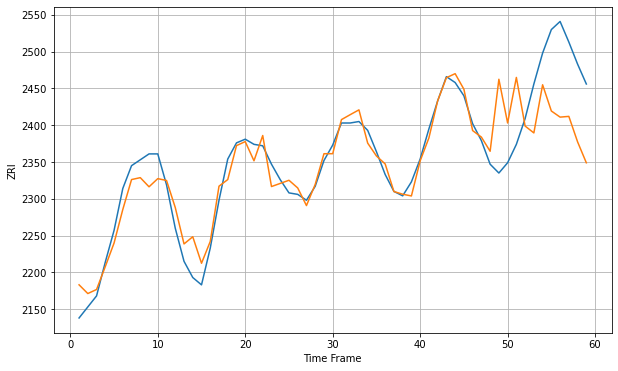

Wall time: 11.7 s
2155 19.747564000383413 89.48844267258251


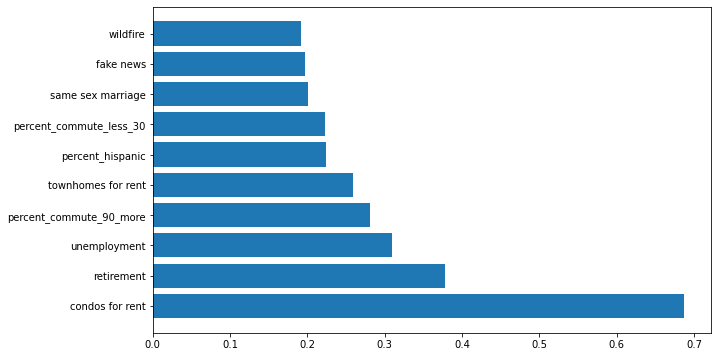


Got an mse at 0.0025 in epoch 71 and stopped training



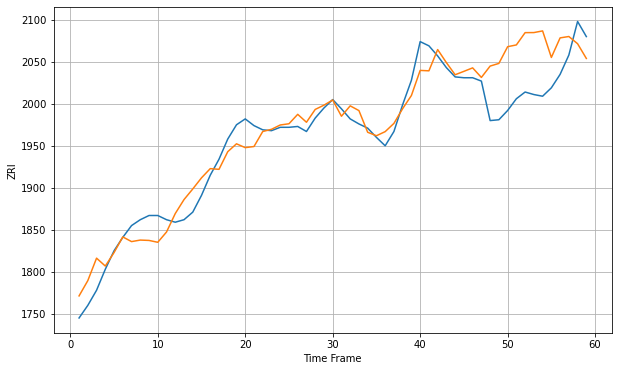

Wall time: 9.54 s
2169 17.80282238205137 57.8310246449639


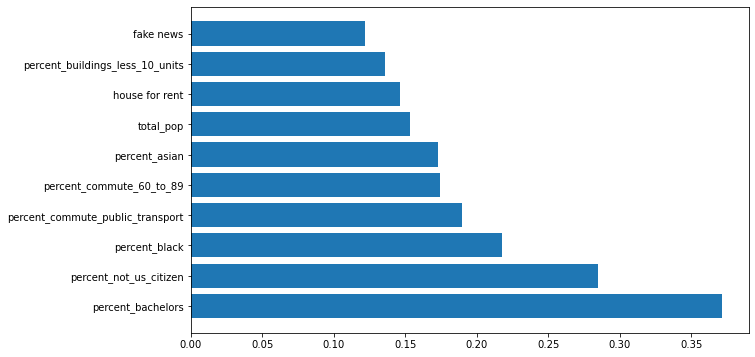


Got an mse at 0.0025 in epoch 169 and stopped training



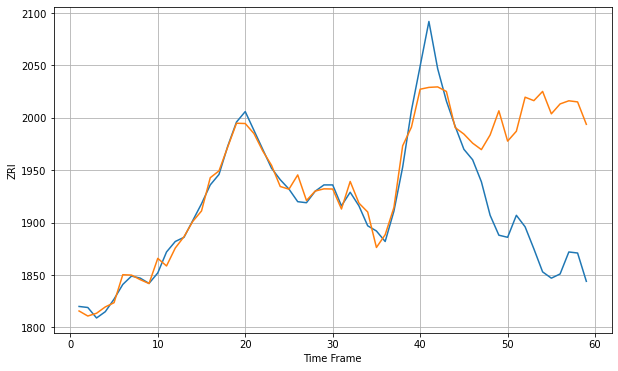

Wall time: 13.1 s
2170 13.937914778315426 133.79662187199682


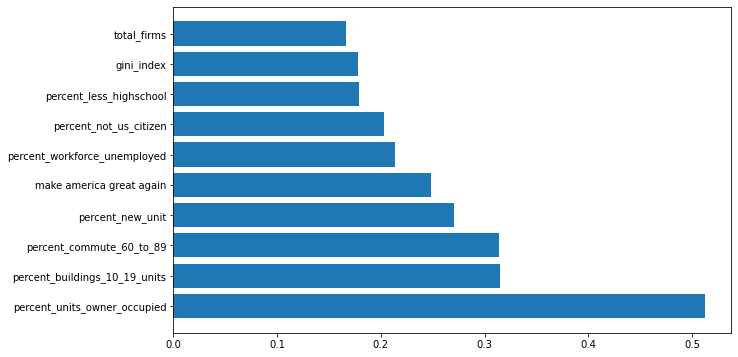


Got an mse at 0.0025 in epoch 45 and stopped training



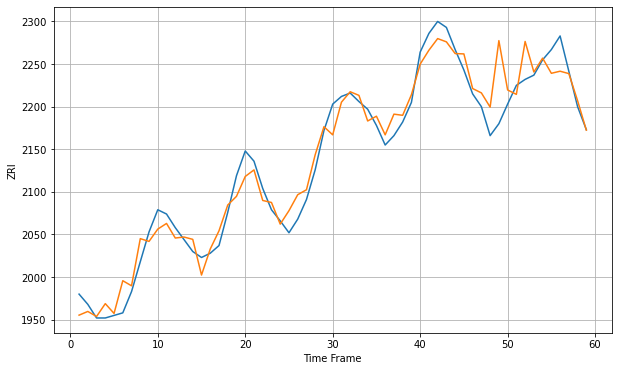

Wall time: 9.7 s
2171 16.97089099250688 36.01027122204341


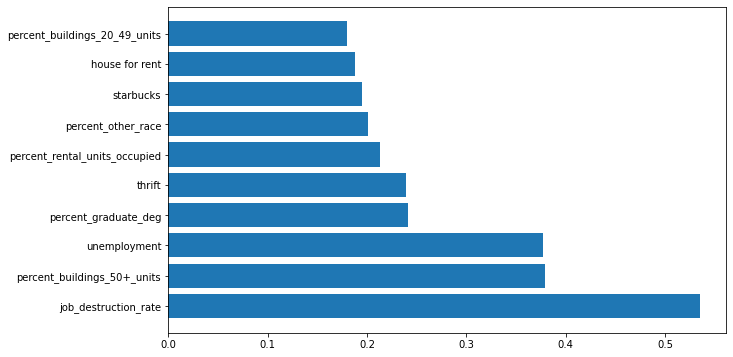


Got an mse at 0.0024 in epoch 36 and stopped training



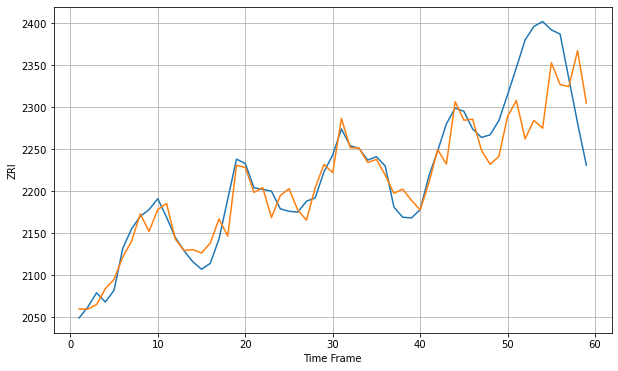

Wall time: 9.59 s
2176 17.31419076759593 74.11585077713197


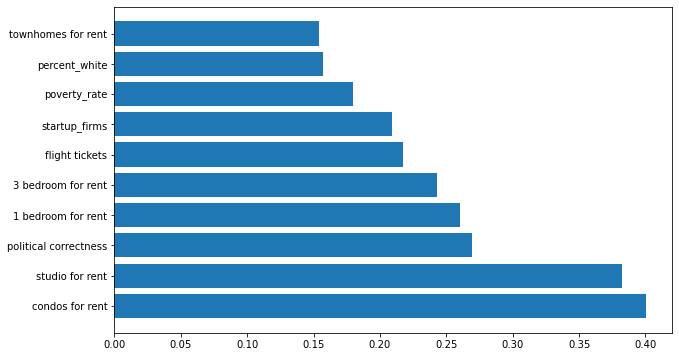


Got an mse at 0.0025 in epoch 183 and stopped training



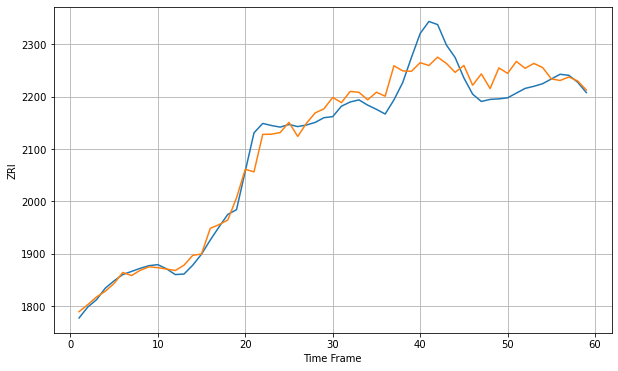

Wall time: 13.6 s
2184 28.874357412932834 34.549259857438926


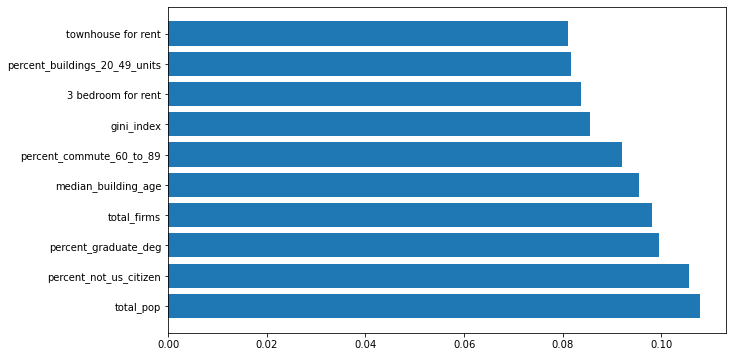


Got an mse at 0.0025 in epoch 77 and stopped training



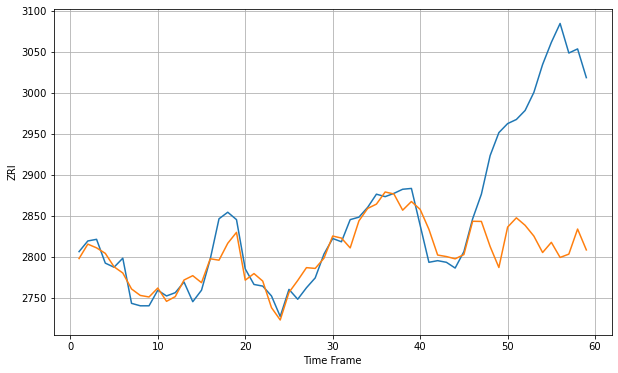

Wall time: 10.8 s
2210 17.386847099197407 196.87866694752574


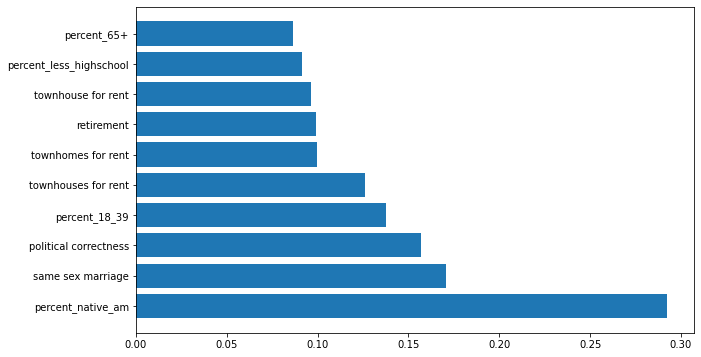


Got an mse at 0.0025 in epoch 69 and stopped training



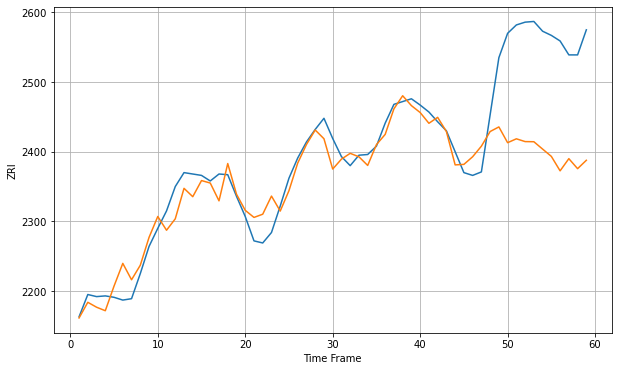

Wall time: 9.95 s
2215 22.793862239591416 157.7349130101661


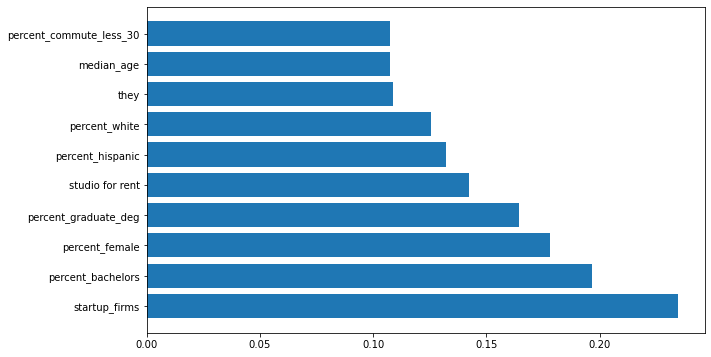


Got an mse at 0.0025 in epoch 87 and stopped training



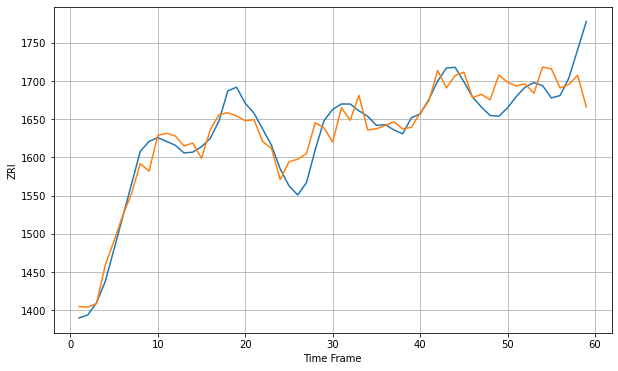

Wall time: 10.7 s
2301 19.44007698937364 41.481643440773205


In [ ]:
score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "importance":[]};
with tf.device('/cpu:0'):
    # for ZONE in zip_ids:
    for ZONE in zip_ids[START_NUM:END_NUM]:
        %time M_train, M_test, model, scaler, series_transformed =\
        NN_test(ZONE, termination=0.0025, plot=True);
        print(ZONE, M_train, M_test);

        score_dict["zip"].append(ZONE);
        score_dict["RMSE_train"].append(M_train);
        score_dict["RMSE_test"].append(M_test);
        
        # Computing the feature importance
        
        results, actual = NN_forecast(model, series_transformed);
        mse = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5;
        perm_importance = [];
        TRIALS = 2;
        PLOT_IMPORTANCE = True;
        
        for i in range(1, len(feature_name)):
            mse_feat = [];
            for _ in range(TRIALS):
                seq_perm = series_transformed.copy();
                seq_perm[:, i] = np.random.permutation(seq_perm[:,i])
                results, actual = NN_forecast(model, seq_perm);
                mse_feat.append(mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5);
                
            perm_importance.append(sum(mse_feat)/TRIALS/mse - 1.0);
        
        importance = pd.DataFrame({"Feature": feature_name[1:], "Importance": perm_importance});
        importance.sort_values("Importance", ascending = False, inplace = True);
        
        plt.figure(figsize=(10, 6));
        plt.barh(importance["Feature"][:10], importance["Importance"][:10]);
        plt.show();
        
        score_dict["importance"].append(perm_importance);

In [18]:
len(score_dict["RMSE_test"])

150

In [16]:
print(sum(score_dict["RMSE_test"])/len(score_dict["RMSE_test"]));

74.05309029401833


In [19]:
test = pd.DataFrame(score_dict);
test.to_csv('NN_feature_window_1_overoverfit_importance_1.csv', index = False);